In [1]:
import os, shutil

import xarray as xr
import dask.dataframe as dd

#from rechunker import rechunk
# need version 0.3.3, see: https://github.com/pangeo-data/rechunker/issues/92

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.plot as pl
import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5666926.datarmor0/parcels-502090/libparcels_random_31df9b16-2ccb-4c78-a4e5-ed1ac6b74241.so


In [2]:
import pandas as pd
import numpy as np

In [3]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3
                 )
#
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.148.1.61:43198' processes=0 threads=0, memory=0 B>

### California

In [5]:
# output archives
out_dir = os.path.join("/home/datawork-lops-osi/equinox/mit4320/diags/", "regional_nwa")
llc_zarr = os.path.join(out_dir, "llc.zarr")

parcels_index= 'time_mean'
parcels_name = "llc_parcels_"+parcels_index
parcels_path = os.path.join(out_dir, parcels_name)


In [6]:
ds = xr.open_zarr(llc_zarr)


In [7]:
ds['zonal_velocity_var'] = (ds['zonal_velocity']-ds['zonal_velocity'].mean('time'))**2
ds['meridional_velocity_var'] = (ds['meridional_velocity']-ds['meridional_velocity'].mean('time'))**2

In [9]:
ds_mean = ds.mean('time').compute()

dfE_mean = ds_mean.drop(['face']).to_dataframe()

In [10]:
def binned_mean(df,dl,bbox,k,group):
    lonmin,lonmax = bbox[0],bbox[1]
    latmin,latmax = bbox[2],bbox[3]
    lon = np.arange(lonmin,lonmax, dl)
    lat = np.arange(latmin, latmax, dl)
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    df_count = df.groupby(group).apply(lambda x:x.count())
    df_count = pa.add_geodata(df_count,lonlat=group)
    df_count = (df_count
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in group])
         .to_xarray()
        )
    df_count = df_count.assign_coords({'lat':np.around(df_count.lat,decimals=k)
                                                     ,'lon':np.around(df_count.lon,decimals=k)})
    if len(group)==1:
        df = df.groupby(group).apply(lambda x:x.mean(skipna=True))
    else:
        df = df.groupby(group).apply(lambda x:x.mean(skipna=False))
    df = pa.add_geodata(df,lonlat=group)
    df = (df
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in group])
         .to_xarray()
        )
    df = df.assign_coords({V.split('_')[0]:np.around(df[V.split('_')[0]],decimals=k) for V in group})
    #df = df.assign_coords({'lat':np.around(df.lat,decimals=k)
    #                                                 ,'lon':np.around(df.lon,decimals=k)})
    return df,df_count

In [11]:
def binned_Lmean(df,dl,bbox,group):
    lonmin,lonmax = bbox[0],bbox[1]#df.lon.values.max()
    latmin,latmax = bbox[2],bbox[3]#df.lat.values.min(),df.lat.values.max()
    lon = np.arange(lonmin,lonmax, dl)
    lat = np.arange(latmin, latmax, dl)
    df['lon'] = (df['lon']+180)%360 - 180
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    df_reset = df.reset_index()
    #group = ['lon_cut','lat_cut']
    df_count = df.groupby(group).count()
    df_count = pa.add_geodata(df_count,lonlat=group)
    df_count = (df_count
     #     .drop(columns=['Coordinates'])
          .set_index([V.split('_')[0] for V in group])
         .to_xarray()
        )
    df_mean = df_reset.drop(columns=['trajectory','z','lat','lon']
                  ).groupby(group).agg(lambda x: x.mean(skipna=False))
    df_mean = df_mean.rename(columns={V:V+'_binned' for V in df_mean.columns})
    df_merged = (df_reset
                 .merge(df_mean.reset_index(), on=group)
                )
    df_merged = df_merged.set_index('time')
    for V in ['zonal_velocity','meridional_velocity']:
        df_merged[V+'_var_ibinned'] = (df_merged[V]-df_merged[V+'_mean_binned'])**2
        df_merged[V+'_var_binned'] = (df_merged[V]-df_merged[V+'_binned'])**2
        df_merged[V+'_var_itime'] = (df_merged[V]-df_merged[V+'_mean'])**2
    df_merged['MKE_itime'] = df_merged['zonal_velocity_mean']**2+df_merged['meridional_velocity_mean']**2
    df_merged['KE'] = df_merged['zonal_velocity']**2+df_merged['meridional_velocity']**2
    #dfL_mean = df_merged.groupby(['lon_cut','lat_cut']).agg(lambda x: x.mean(skipna=False))
    #dfL_mean = pa.add_geodata(dfL_mean)
    #dfL_mean = (dfL_mean
    #          .set_index(['lon', 'lat'])
    #         .to_xarray()
    #        )
    if len(group)==1:
        dfL_mean = df_merged.groupby(group).agg(lambda x: x.mean(skipna=True))
    else:
        dfL_mean = df_merged.groupby(group).agg(lambda x: x.mean(skipna=False))
    dfL_mean = pa.add_geodata(dfL_mean,lonlat=group)
    dfL_mean = (dfL_mean
          .set_index([V.split('_')[0] for V in group])
         .to_xarray()
        )
    return dfL_mean,df_merged,df_count

In [12]:
bbox = [120, 126, -20, -10] # North-west Australia
dl=1.
group = ['lon_cut','lat_cut']
dfE_1dl,dfE_count_1dl = binned_mean(dfE_mean,dl,bbox,1,group)

In [13]:
dl=.1
dfE_01dl,dfE_count_01dl = binned_mean(dfE_mean,dl,bbox,2,group)

In [15]:
dfE_1dlat,dfE_count_1dlat = binned_mean(dfE_mean,1.,bbox,1,['lat_cut'])
dfE_01dlat,dfE_count_01dlat = binned_mean(dfE_mean,.1,bbox,2,['lat_cut'])


TypeError: <lambda>() got an unexpected keyword argument 'axis'

In [16]:
#Lagrangian outputs
df = dd.read_parquet(parcels_path)

In [17]:
df = df.drop(columns=['SST_interp','SSS_interp','Eta_interp','salinity','temperature','sea_level']).rename(columns={'SSU_interp':'zonal_velocity_mean','SSV_interp':'meridional_velocity_mean'})
df = pa.degs2ms(df) #Convert in m/s 


df= df.compute()

In [18]:
group=['lon_cut','lat_cut']
dfL_1dl,df_merged,dfL_count_1dl = binned_Lmean(df,1.,bbox,group=group)
dfL_01dl,df_merged_01, dfL_count_01dl = binned_Lmean(df,0.1,bbox,group=group)

In [19]:
dfL_1dlat,df_merged_1dlat,dfL_count_1dlat = binned_Lmean(df,1.,bbox,['lat_cut'])
dfL_01dlat,df_merged_01dlat,dfL_count_01dlat = binned_Lmean(df,.1,bbox,['lat_cut'])

In [20]:
dfE_1dl['MKE'] = dfE_1dl['zonal_velocity']**2+dfE_1dl['meridional_velocity']**2
dfE_1dl['EKE'] = dfE_1dl['zonal_velocity_var']+dfE_1dl['meridional_velocity_var']
dfL_1dl['MKE_i'] = dfL_1dl['zonal_velocity_mean']**2+dfL_1dl['meridional_velocity_mean']**2
dfL_1dl['MKE_b'] = dfL_1dl['zonal_velocity']**2+dfL_1dl['meridional_velocity']**2
dfL_1dl['EKE_i'] = dfL_1dl['zonal_velocity_var_itime']+dfL_1dl['meridional_velocity_var_itime']
dfL_1dl['EKE_b'] = dfL_1dl['zonal_velocity_var_binned']+dfL_1dl['meridional_velocity_var_binned']

In [21]:
dfE_01dl['MKE'] = dfE_01dl['zonal_velocity']**2+dfE_01dl['meridional_velocity']**2
dfE_01dl['EKE'] = dfE_01dl['zonal_velocity_var']+dfE_01dl['meridional_velocity_var']
dfL_01dl['MKE_i'] = dfL_01dl['zonal_velocity_mean']**2+dfL_01dl['meridional_velocity_mean']**2
dfL_01dl['MKE_b'] = dfL_01dl['zonal_velocity']**2+dfL_01dl['meridional_velocity']**2
dfL_01dl['EKE_i'] = dfL_01dl['zonal_velocity_var_itime']+dfL_01dl['meridional_velocity_var_itime']
dfL_01dl['EKE_b'] = dfL_01dl['zonal_velocity_var_binned']+dfL_01dl['meridional_velocity_var_binned']

In [22]:
dfE_1dlat['MKE'] = dfE_1dlat['zonal_velocity']**2+dfE_1dlat['meridional_velocity']**2
dfE_1dlat['EKE'] = dfE_1dlat['zonal_velocity_var']+dfE_1dlat['meridional_velocity_var']
dfL_1dlat['MKE_i'] = dfL_1dlat['zonal_velocity_mean']**2+dfL_1dlat['meridional_velocity_mean']**2
dfL_1dlat['MKE_b'] = dfL_1dlat['zonal_velocity']**2+dfL_1dlat['meridional_velocity']**2
dfL_1dlat['EKE_i'] = dfL_1dlat['zonal_velocity_var_itime']+dfL_1dlat['meridional_velocity_var_itime']
dfL_1dlat['EKE_b'] = dfL_1dlat['zonal_velocity_var_binned']+dfL_1dlat['meridional_velocity_var_binned']

In [24]:
#dfE_01dlat['MKE'] = dfE_01dlat['zonal_velocity']**2+dfE_01dlat['meridional_velocity']**2
#dfE_01dlat['EKE'] = dfE_01dlat['zonal_velocity_var']+dfE_01dlat['meridional_velocity_var']
dfL_01dlat['MKE_i'] = dfL_01dlat['zonal_velocity_mean']**2+dfL_01dlat['meridional_velocity_mean']**2
dfL_01dlat['MKE_b'] = dfL_01dlat['zonal_velocity']**2+dfL_01dlat['meridional_velocity']**2
dfL_01dlat['EKE_i'] = dfL_01dlat['zonal_velocity_var_itime']+dfL_01dlat['meridional_velocity_var_itime']
dfL_01dlat['EKE_b'] = dfL_01dlat['zonal_velocity_var_binned']+dfL_01dlat['meridional_velocity_var_binned'
                                                                        ]

### Visualization

In [25]:
tracks = ut.load_swot_tracks()

In [26]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
def plot_site(bbox,k,colmap='RdBu_r',figsize=(5,5)):

    central_lon = (bbox[0]+bbox[1])*0.5
    central_lat = (bbox[2]+bbox[3])*0.5

    polygon = Polygon([(bbox[0], bbox[2]), 
                       (bbox[1], bbox[2]), 
                       (bbox[1], bbox[3]), 
                       (bbox[0], bbox[3]), 
                       (bbox[0], bbox[2]),
                      ])
    #poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
    gdf = tracks["swath"]
    gdf_clipped = gpd.clip(gdf, polygon)

    #crs = ccrs.Orthographic(central_lon, central_lat)
    crs = ccrs.AlbersEqualArea(central_lon, central_lat)

    crs_proj4 = crs.proj4_init

    fig, ax = plt.subplots(1, k, 
                           subplot_kw={'projection': crs},
                           figsize=figsize,
                          )
    #ds_Lstats[V].plot(ax=ax,transform=ccrs.PlateCarree(),y='lat',vmax=vmax,cmap=colmap)
#    ax.set_extent(bbox)

    #_gdf = gdf.cx[bbox[0]:bbox[1], bbox[2]:bbox[3]]
    _gdf = gdf_clipped
    gdf_crs = _gdf.to_crs(crs_proj4)
    for a in ax:
        a.add_geometries(gdf_crs['geometry'],
                          crs=crs,
                          facecolor='grey', 
                          edgecolor='black',
                          alpha=0.5,
                         )

        a.gridlines(draw_labels=True)
    #    ax.coastlines(resolution='50m')
        a.set_extent(bbox)
    return fig, ax

In [27]:
def plot_swot(df,col,bbox,k,vmax,colmap,figsize):
    fig,ax = plot_site(bbox,k,figsize=figsize)
    if k!=1:
        for V,c,a in zip(df,col,ax):
            V.plot.scatter(ax=a,transform=ccrs.PlateCarree(),x='lon',y='lat',c=c,s=5,cmap=colmap,vmax=vmax)
    else:
        df.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat',c=col,s=5,cmap=colmap,vmax=vmax)
    fig.tight_layout()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


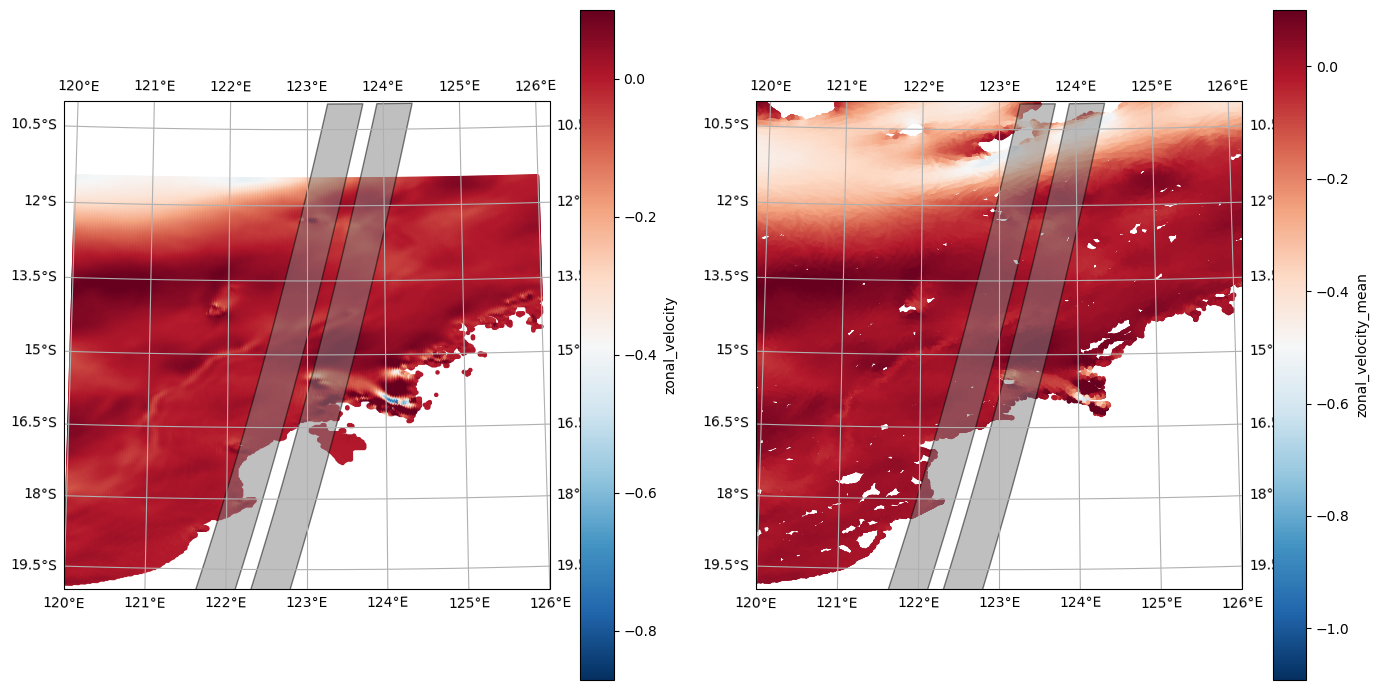

In [21]:
import geopandas as gdp
colmap='RdBu_r'
plot_swot([ds_mean.drop(['face']).to_dataframe(),df],['zonal_velocity','zonal_velocity_mean'],bbox,2,0.1,colmap,(14,7))

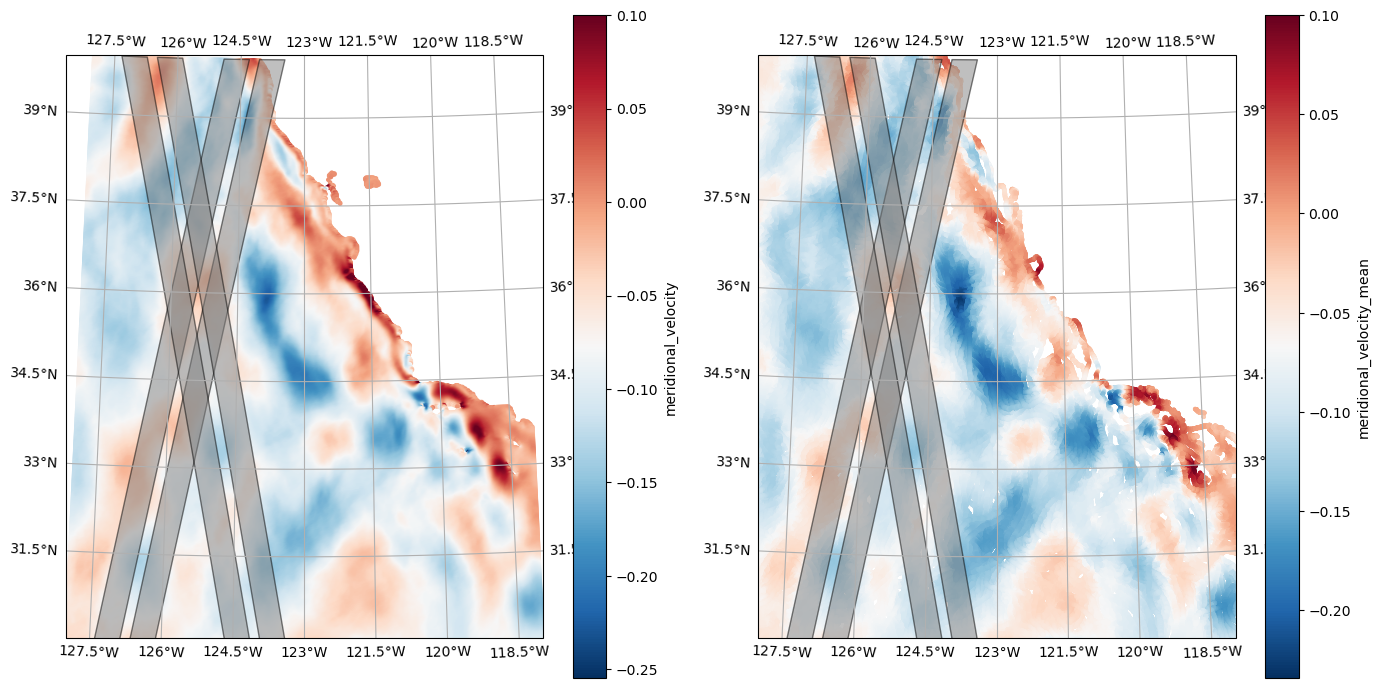

In [40]:
plot_swot([ds_mean.drop(['face']).to_dataframe(),df],['meridional_velocity','meridional_velocity_mean'],bbox,2,0.1,colmap,(14,7))

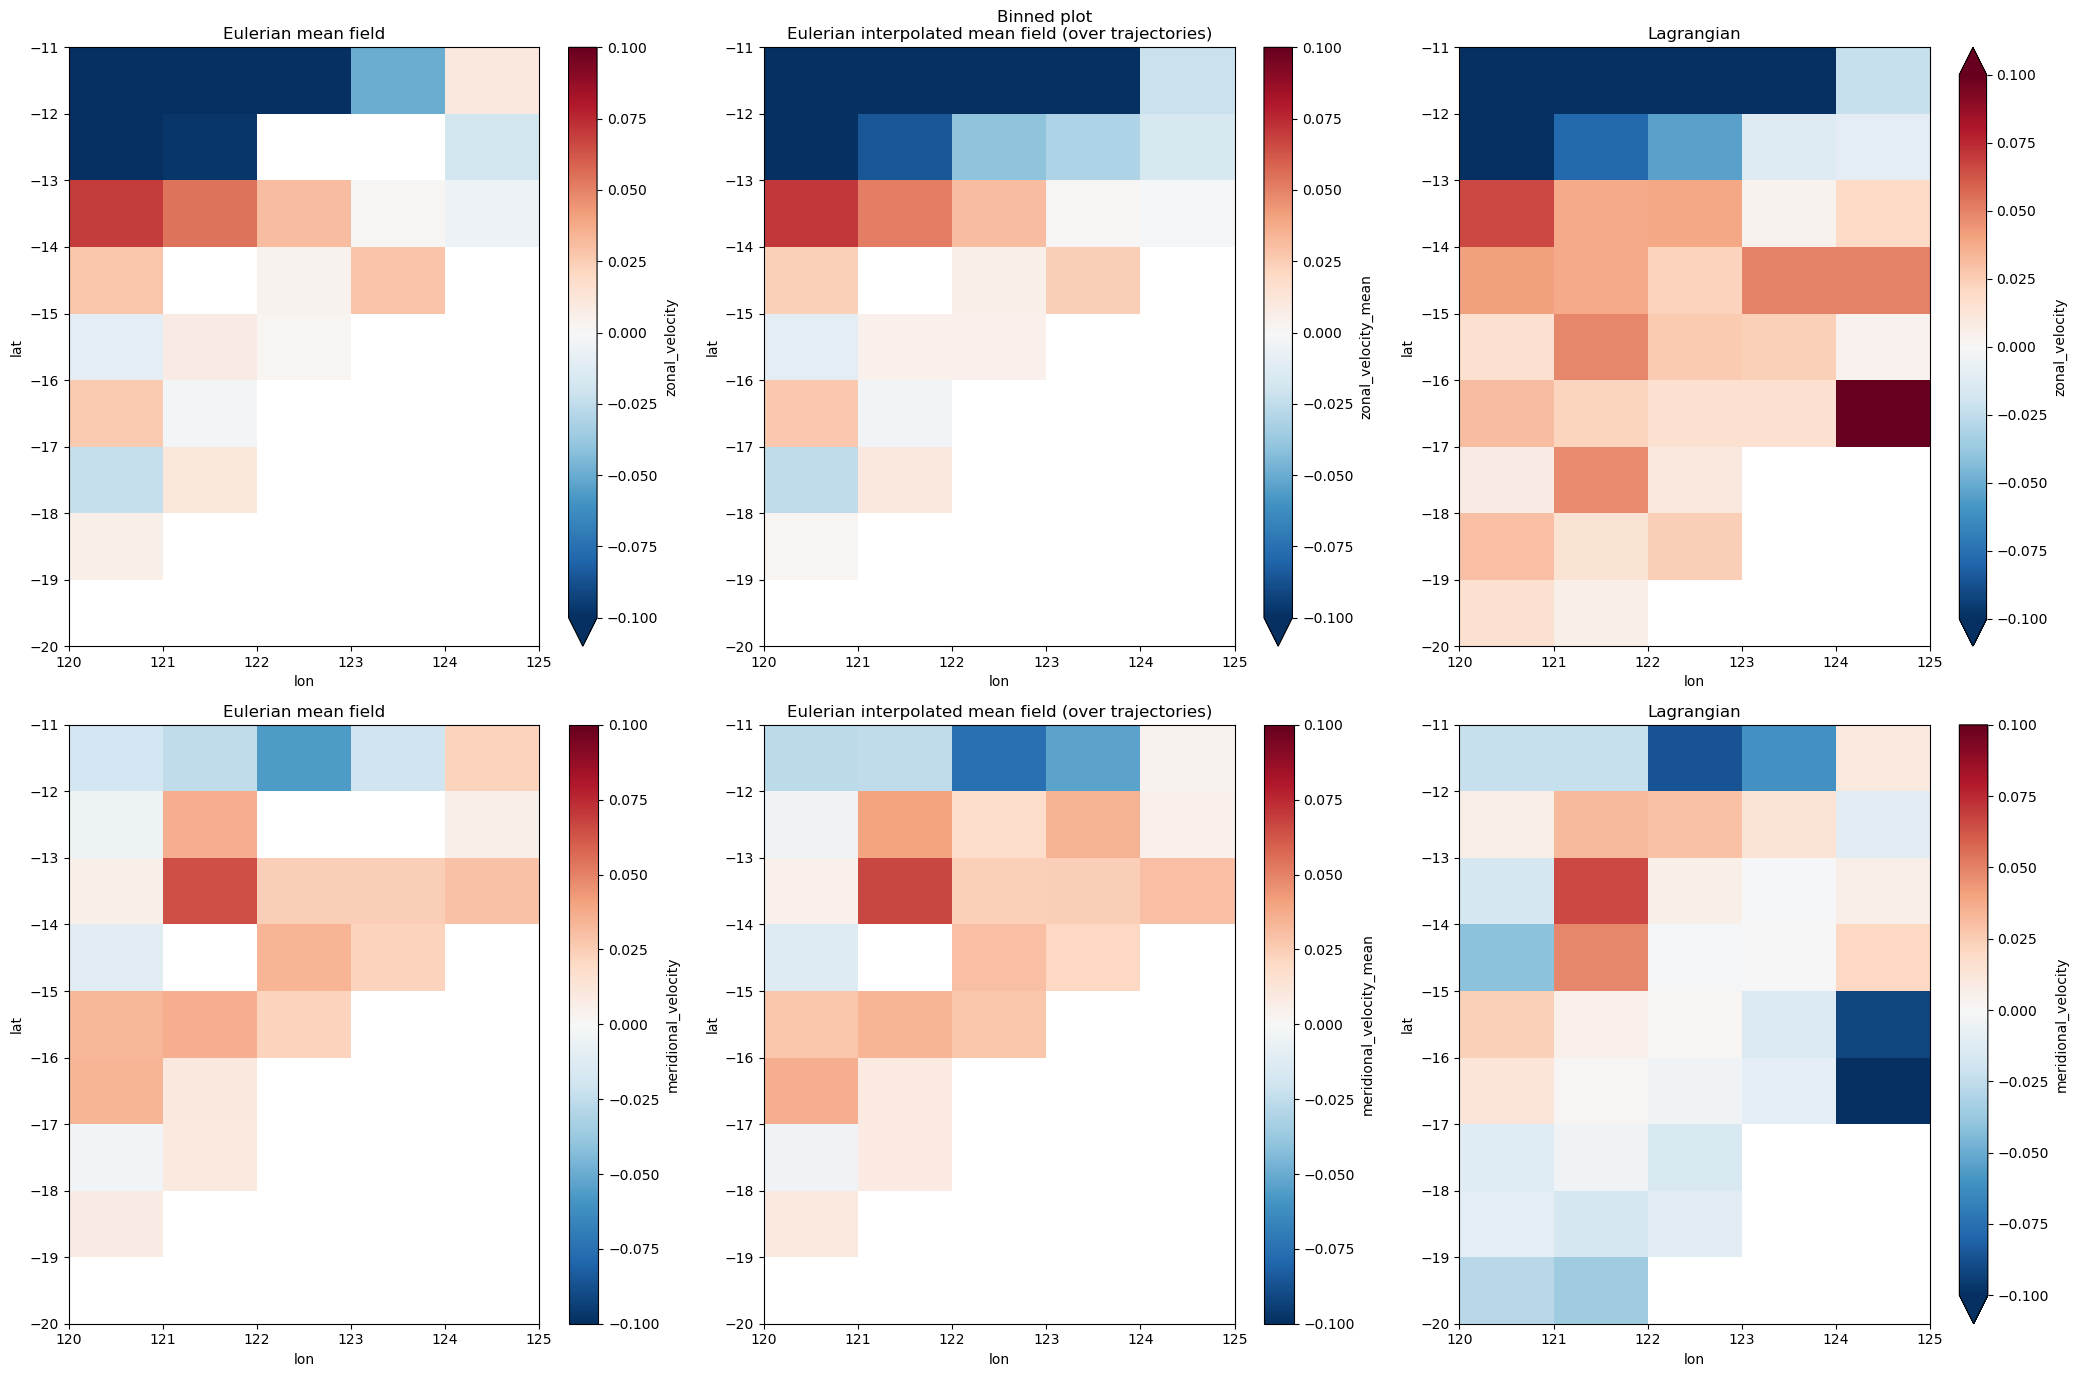

In [22]:
vmax=0.1
fig, axs = plt.subplots(2, 3, 
                           figsize=(21,14),
                          )
for i,V in enumerate(['zonal_velocity','meridional_velocity']):
    dfE_1dl[V].plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,0],vmax=vmax)
    dfL_1dl[V+'_mean'].plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,1],vmax=vmax)
    dfL_1dl[V].plot(x='lon',y='lat',cmap='RdBu_r',ax=axs[i,2],vmax=vmax)

    for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs[i,:]):
        ax.set_title(title)
fig.suptitle('Binned plot')
fig.tight_layout()

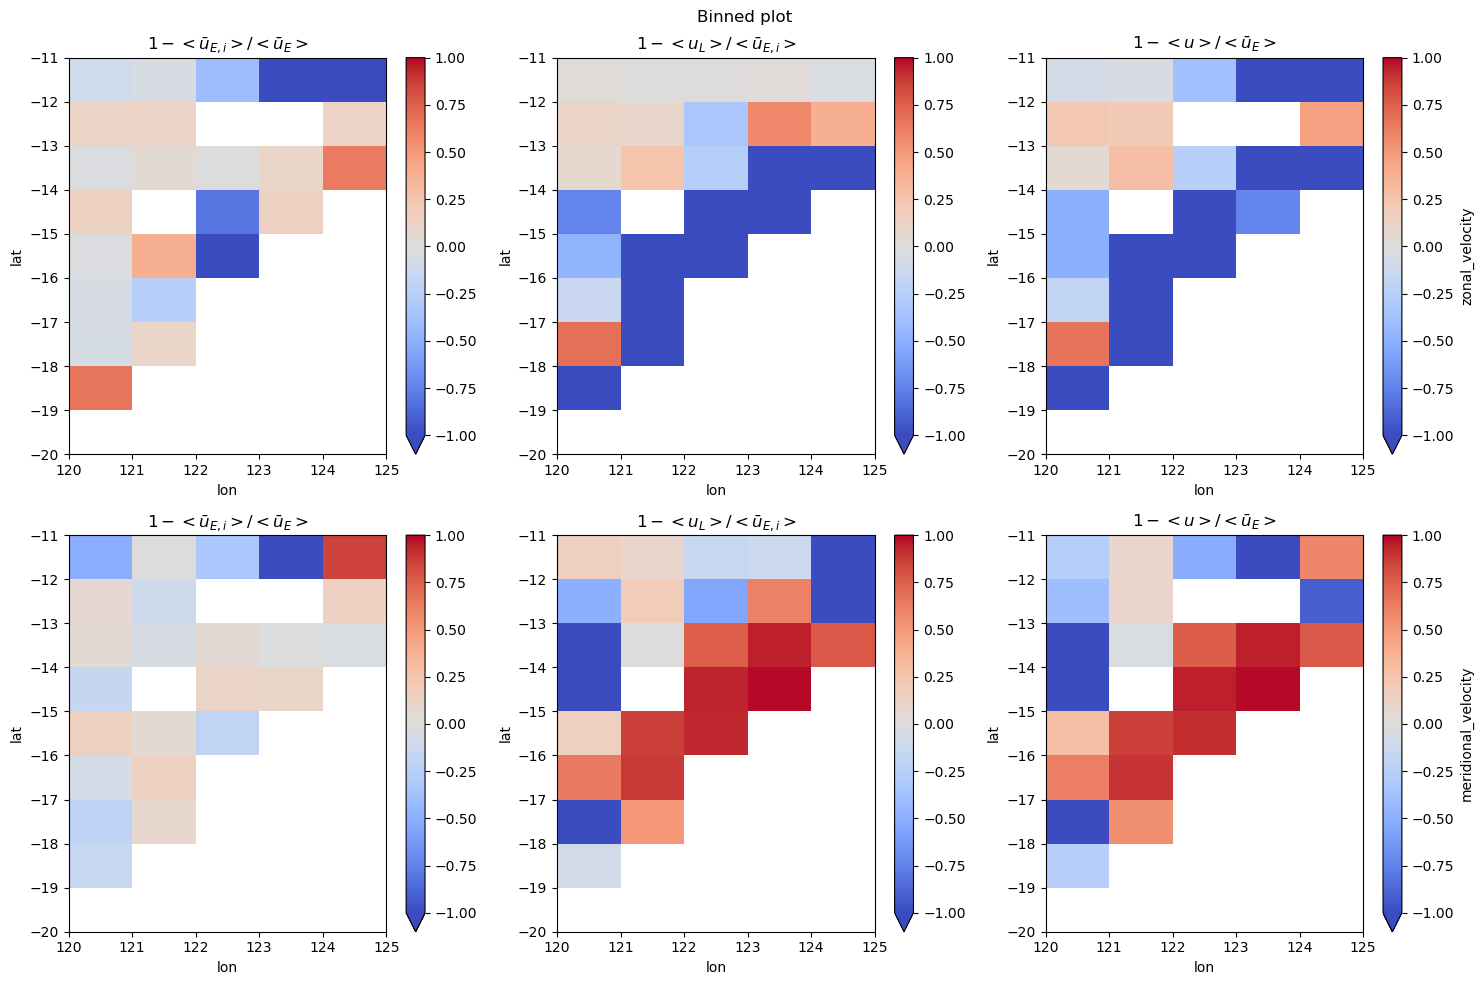

In [23]:
cmap='coolwarm'
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity','meridional_velocity']):
    (1-np.abs(dfL_1dl[V+'_mean']/dfE_1dl[V])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,0],vmax=1)
    (1-np.abs(dfL_1dl[V]/dfL_1dl[V+'_mean'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,1],vmax=1)
    (1-np.abs(dfL_1dl[V]/dfE_1dl[V])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,2],vmax=1)

    for title,ax in zip([r'$1-<\bar u_{E,i}>/<\bar u_E>$',r'$1-<u_L>/<\bar u_{E,i}>$',r'$1-<u>/<\bar u_E>$'],axs[i,:]):
        ax.set_title(title)

fig.suptitle('Binned plot')
fig.tight_layout()
#fig,ax = plt.subplots(1,3,figsize=(15,5))
#df_count.plot(y='lat',ax=ax[0])
#dfL_mean['count'].plot(y='lat',ax=ax[1])
#(dfL_mean['count']/df_count).plot(y='lat',ax=ax[2])
#fig.tight_layout()

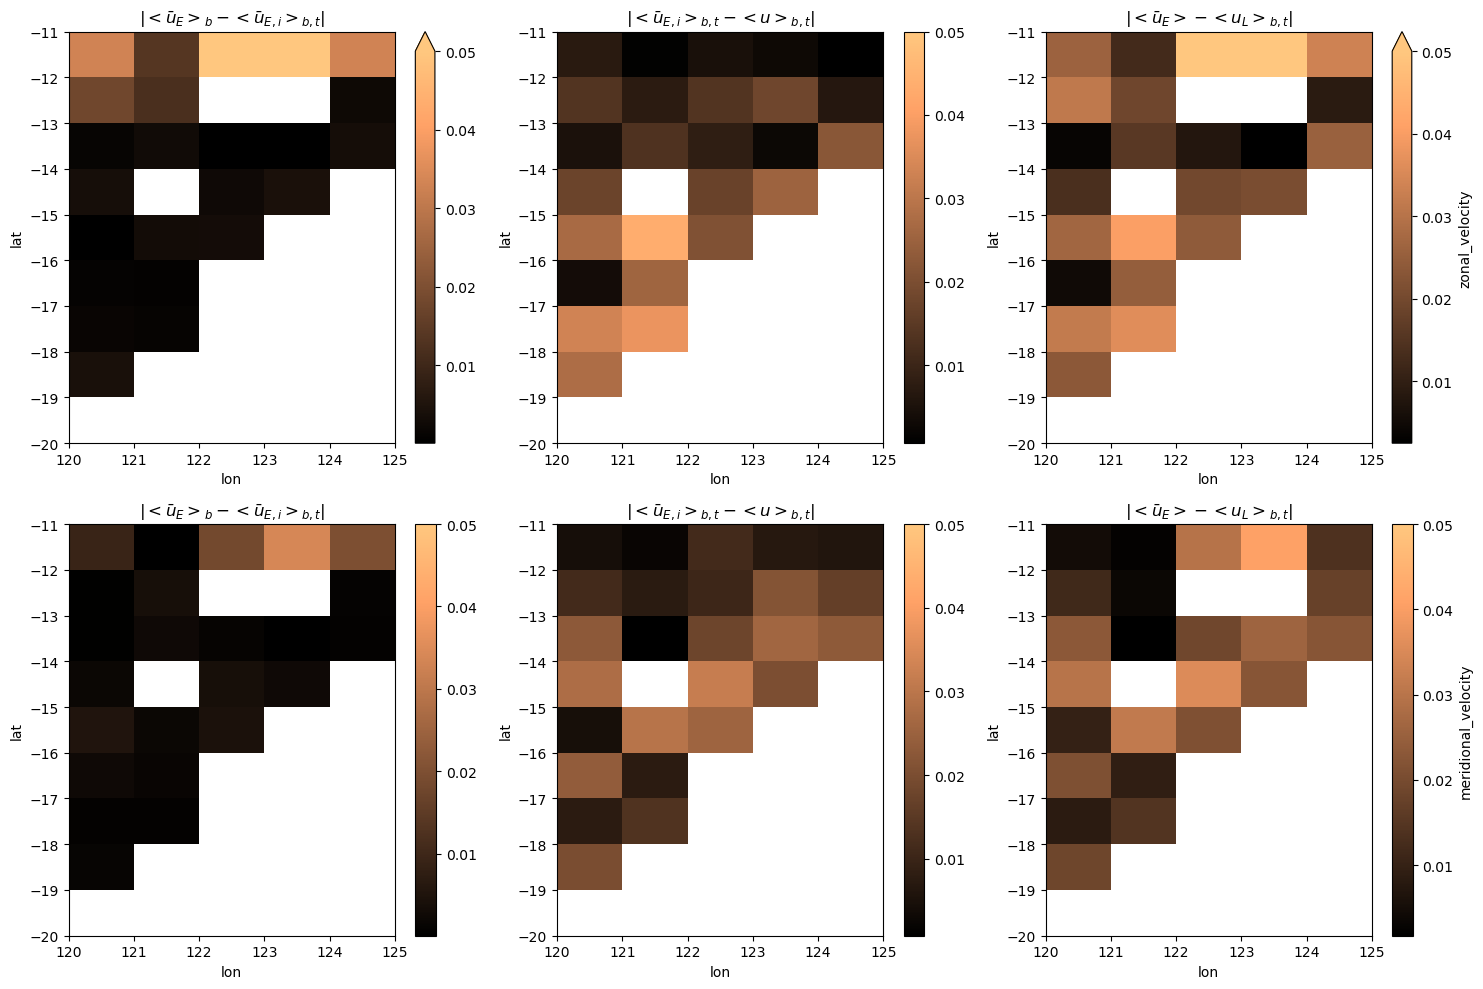

In [24]:
cmap='copper'
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity','meridional_velocity']):
    np.abs(dfE_1dl[V]-dfL_1dl[V+'_mean']).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,0],vmax=0.05)
    np.abs(dfL_1dl[V+'_mean']-dfL_1dl[V]).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,1],vmax=0.05)
    np.abs(dfE_1dl[V]-dfL_1dl[V]).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,2],vmax=0.05)

    for title,ax in zip([r'$\vert <\bar u_E>_b-<\bar u_{E,i}>_{b,t}\vert$',r'$\vert <\bar u_{E,i}>_{b,t}-<u>_{b,t}\vert$',r'$\vert<\bar u_E>-<u_L>_{b,t}\vert$'],axs[i,:]):
        ax.set_title(title)

fig.tight_layout()
#fig,ax = plt.subplots(1,3,figsize=(15,5))
#df_count.plot(y='lat',ax=ax[0])
#dfL_1dl['count'].plot(y='lat',ax=ax[1])
#dfL_1dl['count']/dfE_1dl['count']).plot(y='lat',ax=ax[2])
#fig.tight_layout()

### MKE

In [25]:
#plot_swot([ds_mean.drop(['face']).to_dataframe(),df_merged],['MKE_time','MKE_itime'],bbox,2,0.1,,(14,7))

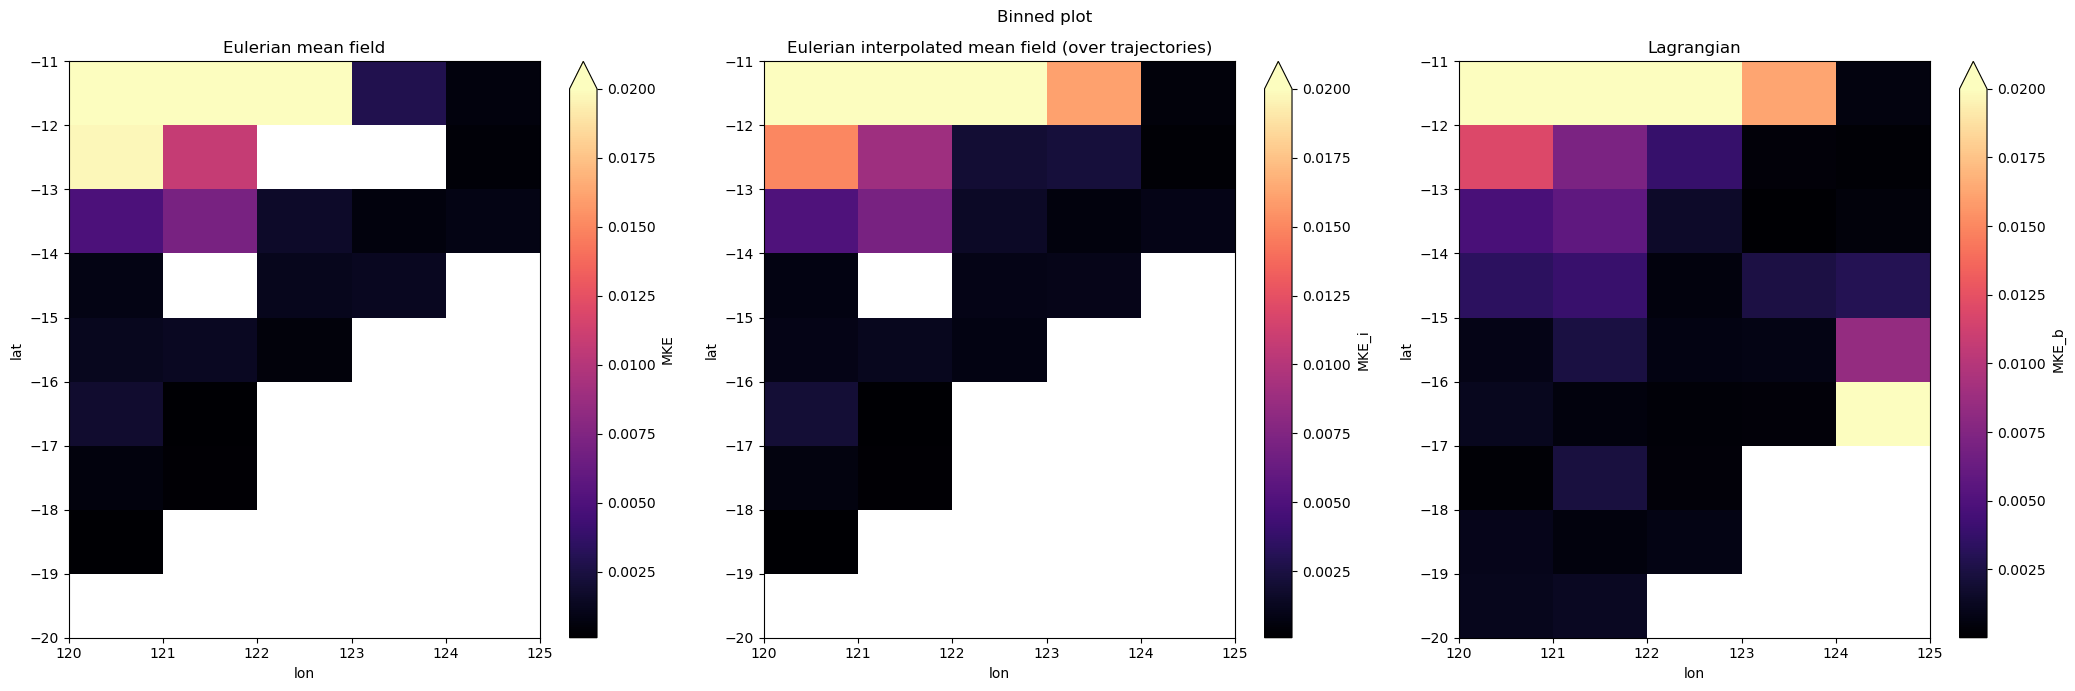

In [28]:
vmax=0.02
fig, axs = plt.subplots(1, 3, 
                           figsize=(21,7),
                          )

dfE_1dl['MKE'].plot(x='lon',y='lat',cmap='magma',ax=axs[0],vmax=vmax)
dfL_1dl['MKE_i'].plot(x='lon',y='lat',cmap='magma',ax=axs[1],vmax=vmax)
dfL_1dl['MKE_b'].plot(x='lon',y='lat',cmap='magma',ax=axs[2],vmax=vmax)

for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs):
    ax.set_title(title)
fig.suptitle('Binned plot')
fig.tight_layout()

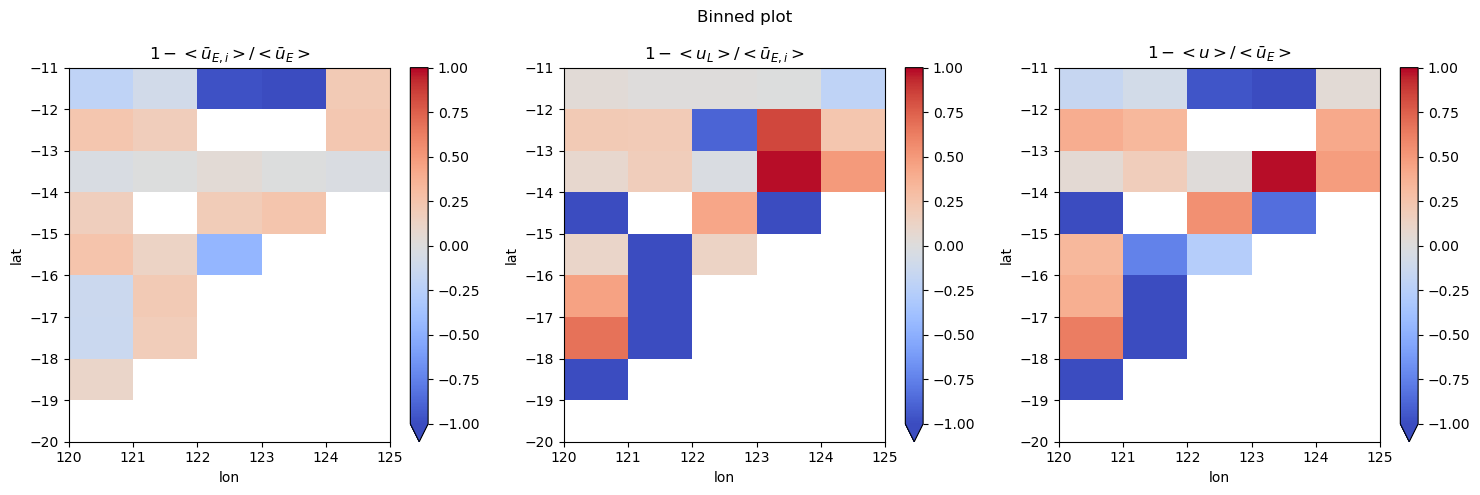

In [28]:
cmap='coolwarm'
fig, axs = plt.subplots(1,3,figsize=(15,5))
(1-np.abs(dfL_1dl['MKE_i']/dfE_1dl['MKE'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[0],vmax=1)
(1-np.abs(dfL_1dl['MKE_b']/dfL_1dl['MKE_i'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[1],vmax=1)
(1-np.abs(dfL_1dl['MKE_b']/dfE_1dl['MKE'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[2],vmax=1)

for title,ax in zip([r'$1-<\bar u_{E,i}>/<\bar u_E>$',r'$1-<u_L>/<\bar u_{E,i}>$',r'$1-<u>/<\bar u_E>$'],axs[:]):
    ax.set_title(title)

fig.suptitle('Binned plot')
fig.tight_layout()

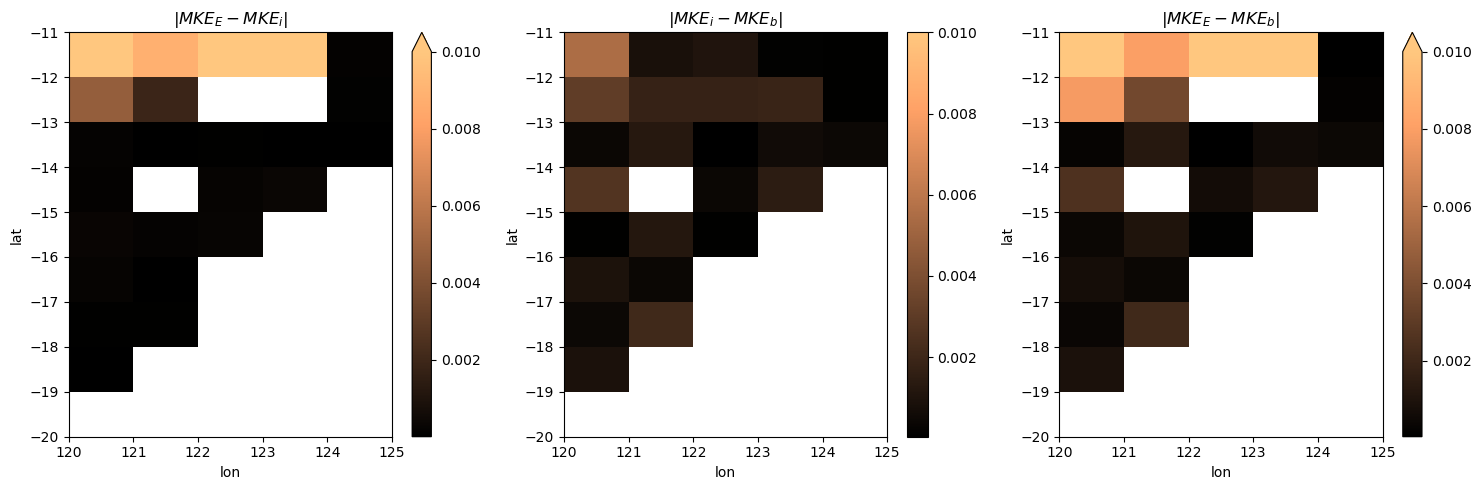

In [29]:
cmap='copper'
fig, axs = plt.subplots(1,3,figsize=(15,5))
np.abs(dfE_1dl['MKE']-dfL_1dl['MKE_i']).plot(x='lon',y='lat',cmap=cmap,ax=axs[0],vmax=0.01)
np.abs(dfL_1dl['MKE_i']-dfL_1dl['MKE_b']).plot(x='lon',y='lat',cmap=cmap,ax=axs[1],vmax=0.01)
np.abs(dfE_1dl['MKE']-dfL_1dl['MKE_b']).plot(x='lon',y='lat',cmap=cmap,ax=axs[2],vmax=0.01)

for title,ax in zip([r'$\vert MKE_E-MKE_i\vert$',r'$\vert MKE_i-MKE_b\vert$',r'$\vert MKE_E-MKE_b\vert$'],axs[:]):
    ax.set_title(title)

fig.tight_layout()

### Variance

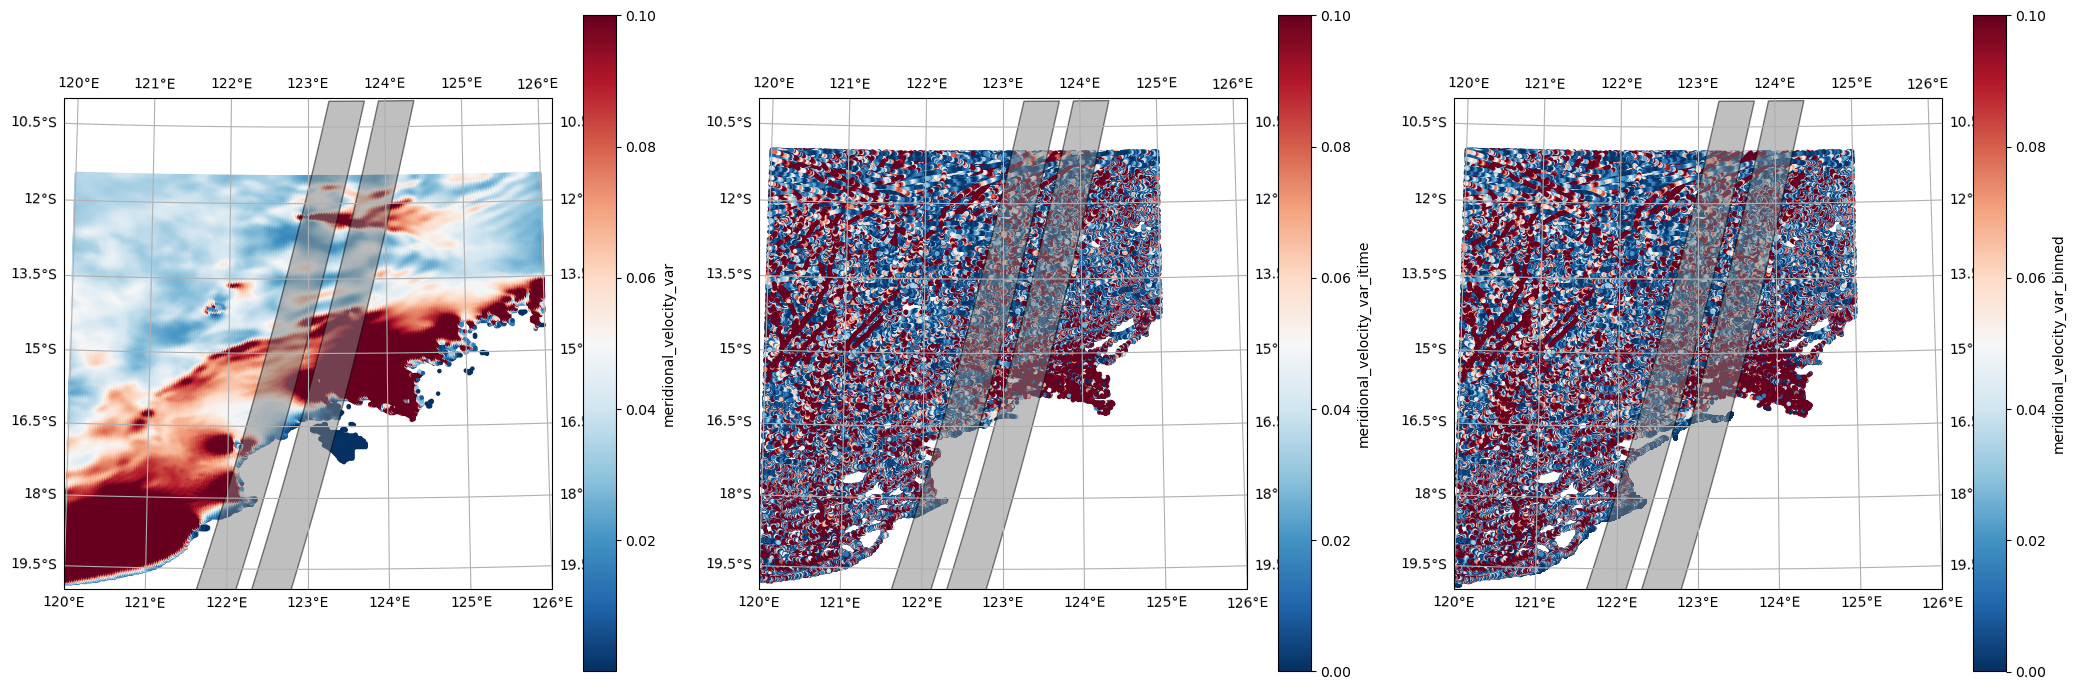

In [30]:
plot_swot([ds_mean.drop(['face']).to_dataframe(),df_merged,df_merged],
          ['meridional_velocity_var','meridional_velocity_var_itime','meridional_velocity_var_binned'],bbox,3,0.1,colmap,(21,7))

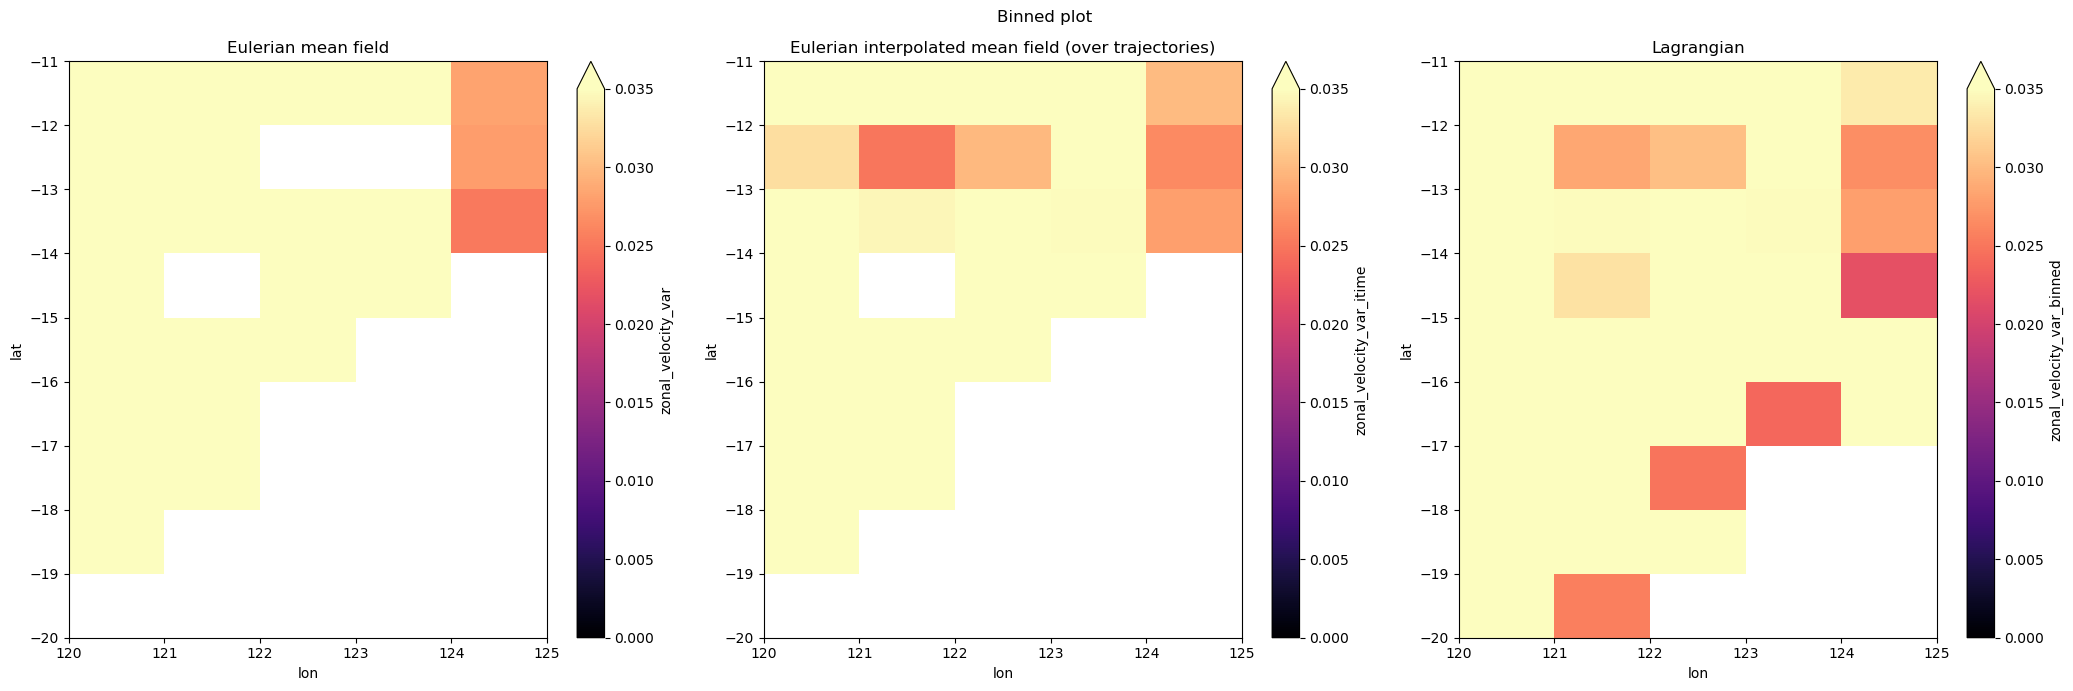

In [34]:
vmax=0.035
fig, axs = plt.subplots(1, 3, 
                           figsize=(21,7),
                          )

dfE_1dl['zonal_velocity_var'].plot(x='lon',y='lat',cmap='magma',ax=axs[0],vmax=vmax,vmin=0)
dfL_1dl['zonal_velocity_var_itime'].plot(x='lon',y='lat',cmap='magma',ax=axs[1],vmax=vmax,vmin=0)
dfL_1dl['zonal_velocity_var_binned'].plot(x='lon',y='lat',cmap='magma',ax=axs[2],vmax=vmax,vmin=0)

for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs):
    ax.set_title(title)
fig.suptitle('Binned plot')
fig.tight_layout()

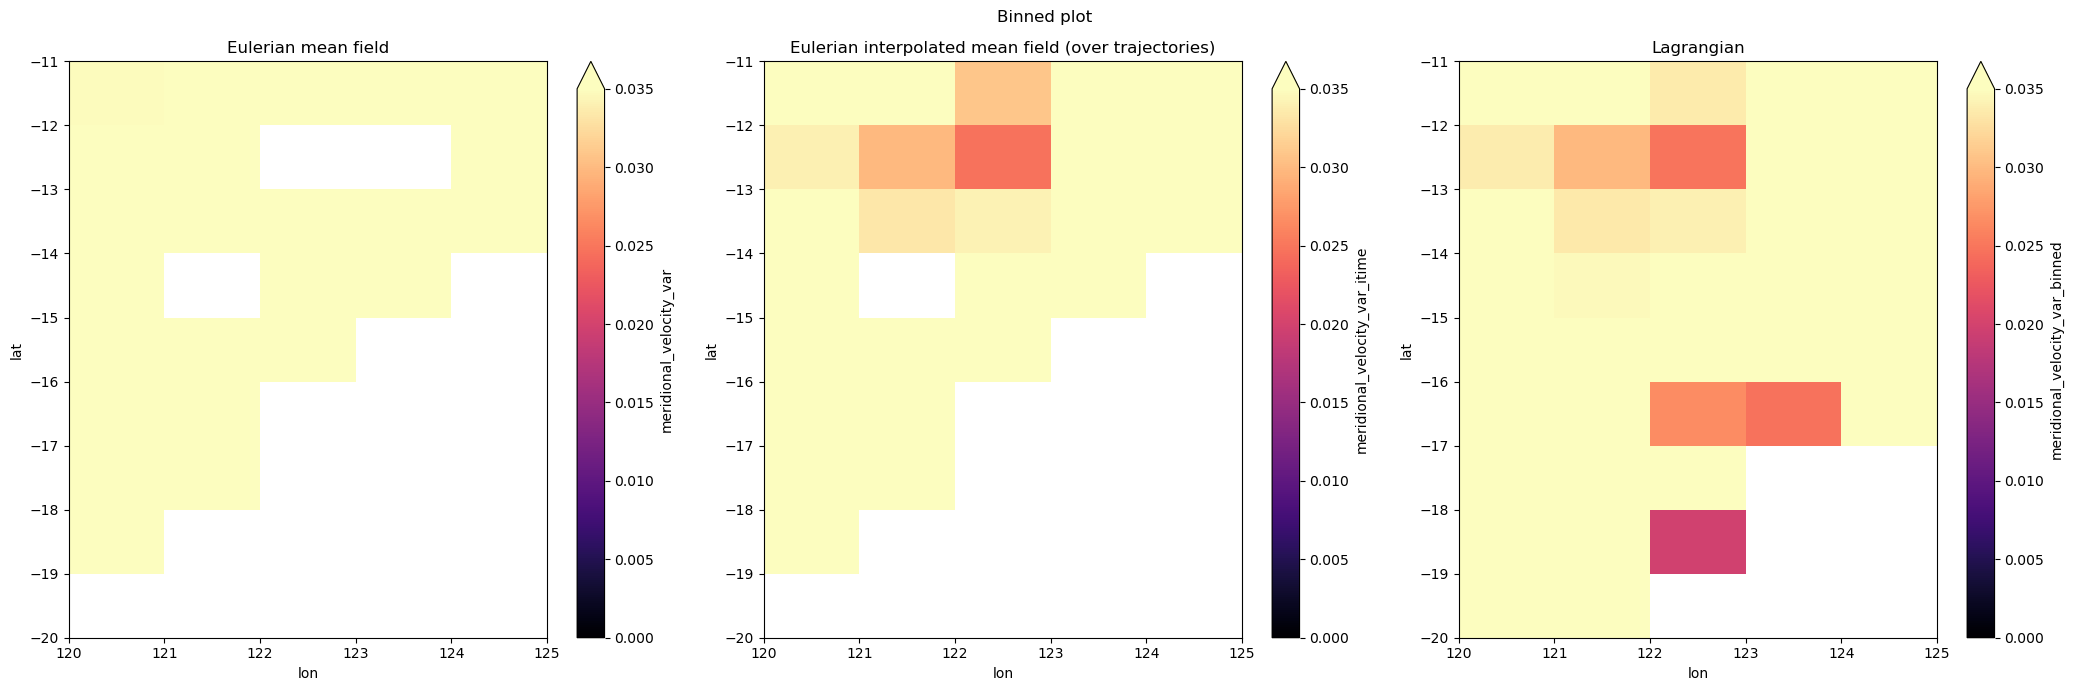

In [35]:
vmax=0.035
fig, axs = plt.subplots(1, 3, 
                           figsize=(21,7),
                          )

dfE_1dl['meridional_velocity_var'].plot(x='lon',y='lat',cmap='magma',ax=axs[0],vmax=vmax,vmin=0)
dfL_1dl['meridional_velocity_var_itime'].plot(x='lon',y='lat',cmap='magma',ax=axs[1],vmax=vmax,vmin=0)
dfL_1dl['meridional_velocity_var_binned'].plot(x='lon',y='lat',cmap='magma',ax=axs[2],vmax=vmax,vmin=0)

for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs):
    ax.set_title(title)
fig.suptitle('Binned plot')
fig.tight_layout()

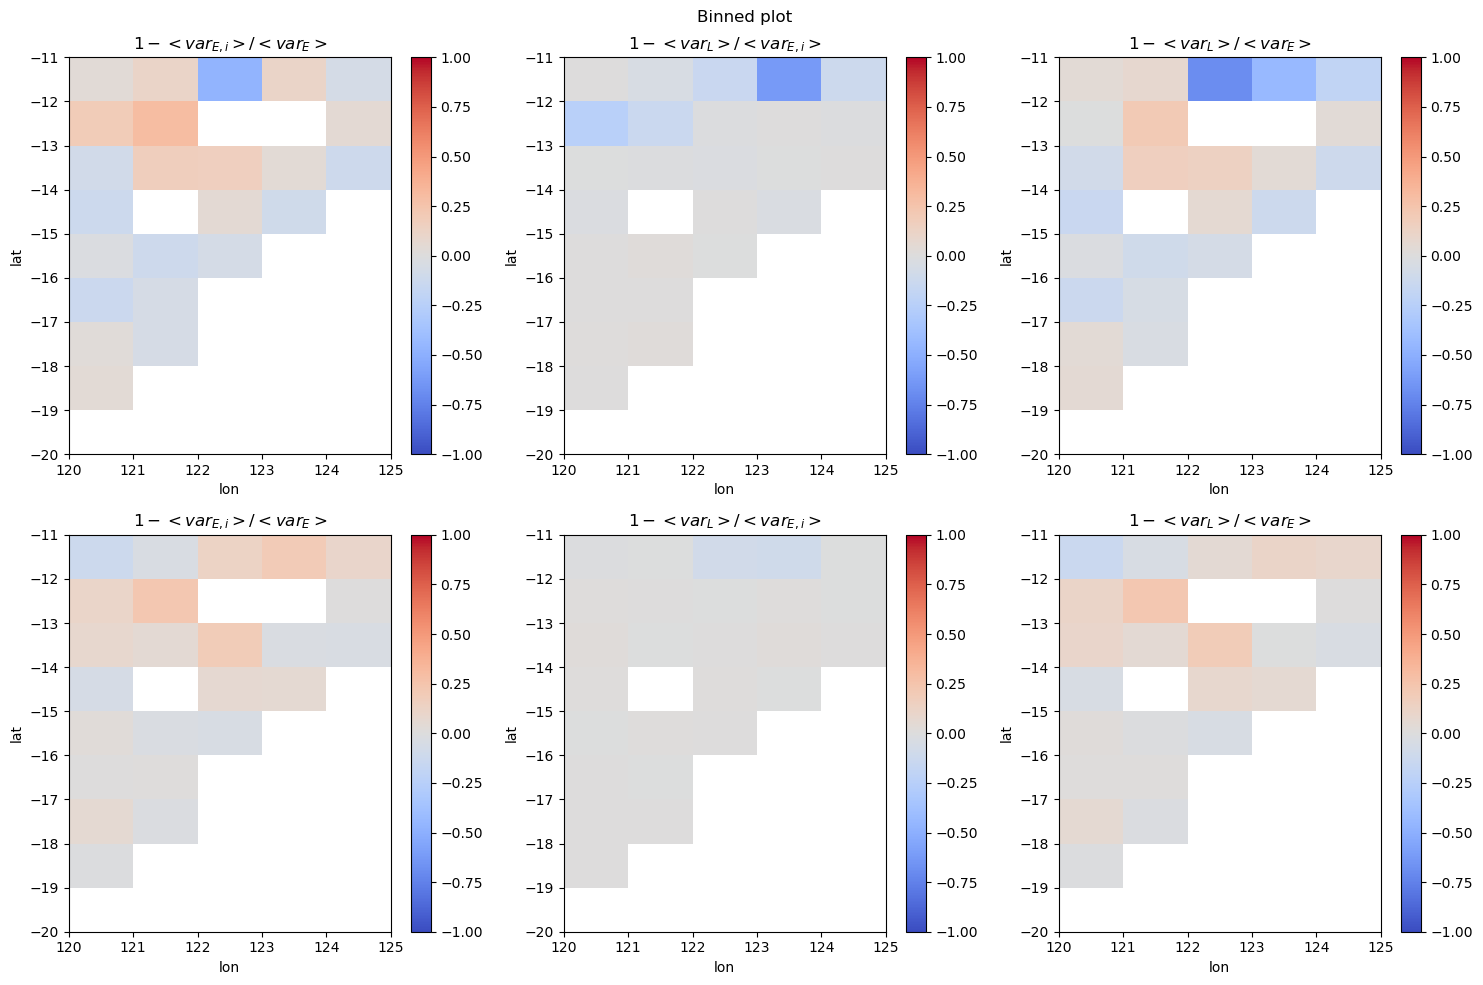

In [36]:
cmap='coolwarm'
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity_var','meridional_velocity_var']):
    (1-np.abs(dfL_1dl[V+'_itime']/dfE_1dl[V])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,0],vmax=1)
    (1-np.abs(dfL_1dl[V+'_binned']/dfL_1dl[V+'_itime'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,1],vmax=1)
    (1-np.abs(dfL_1dl[V+'_binned']/dfE_1dl[V])).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,2],vmax=1)

    for title,ax in zip([r'$1-<var_{E,i}>/<var_E>$',r'$1-<var_L>/<var_{E,i}>$',r'$1-<var_L>/<var_E>$'],axs[i,:]):
        ax.set_title(title)

fig.suptitle('Binned plot')
fig.tight_layout()

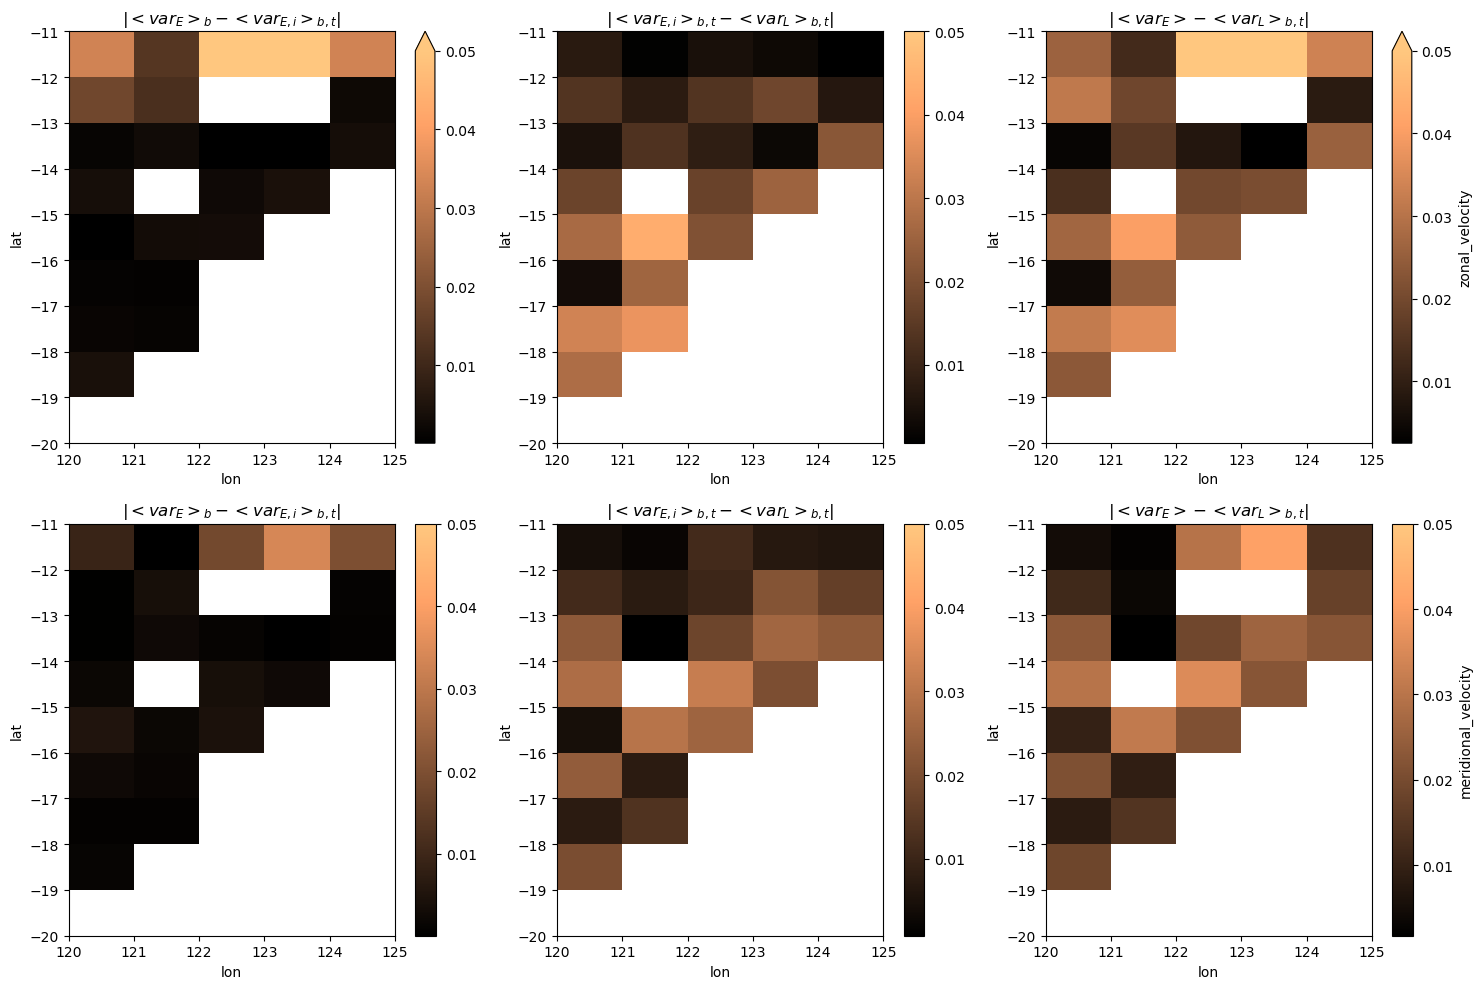

In [37]:
cmap='copper'
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i,V in enumerate(['zonal_velocity','meridional_velocity']):
    np.abs(dfE_1dl[V]-dfL_1dl[V+'_mean']).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,0],vmax=0.05)
    np.abs(dfL_1dl[V+'_mean']-dfL_1dl[V]).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,1],vmax=0.05)
    np.abs(dfE_1dl[V]-dfL_1dl[V]).plot(x='lon',y='lat',cmap=cmap,ax=axs[i,2],vmax=0.05)

    for title,ax in zip([r'$\vert <var_E>_b-<var_{E,i}>_{b,t}\vert$',r'$\vert <var_{E,i}>_{b,t}-<var_L>_{b,t}\vert$',r'$\vert<var_E>-<var_L>_{b,t}\vert$'],axs[i,:]):
        ax.set_title(title)

fig.tight_layout()

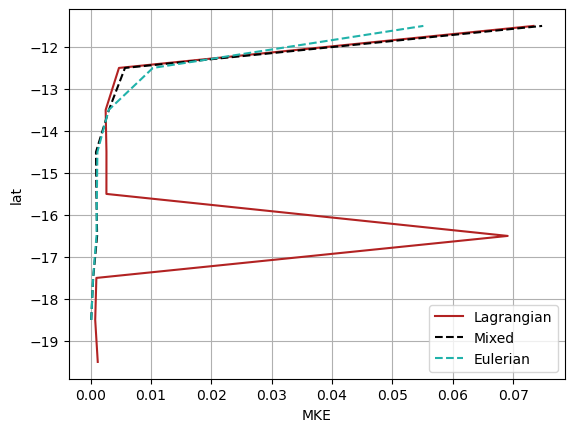

In [30]:
dfL_1dl.mean('lon').MKE_b.plot(y='lat',c='firebrick',label=r'Lagrangian')
dfL_1dl.mean('lon').MKE_i.plot(y='lat',c='k',linestyle='--',label=r'Mixed')
dfE_1dl.mean('lon').MKE.plot(y='lat',c='lightseagreen',linestyle='--',label=r'Eulerian')
plt.legend();plt.grid()

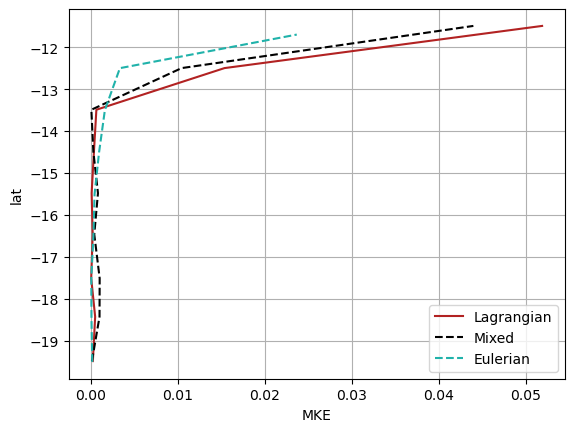

In [31]:
dfL_1dlat.MKE_b.plot(y='lat',c='firebrick',label=r'Lagrangian')
dfL_1dlat.MKE_i.plot(y='lat',c='k',linestyle='--',label=r'Mixed')
dfE_1dlat.MKE.plot(y='lat',c='lightseagreen',linestyle='--',label=r'Eulerian')
plt.legend();plt.grid()

### EKE

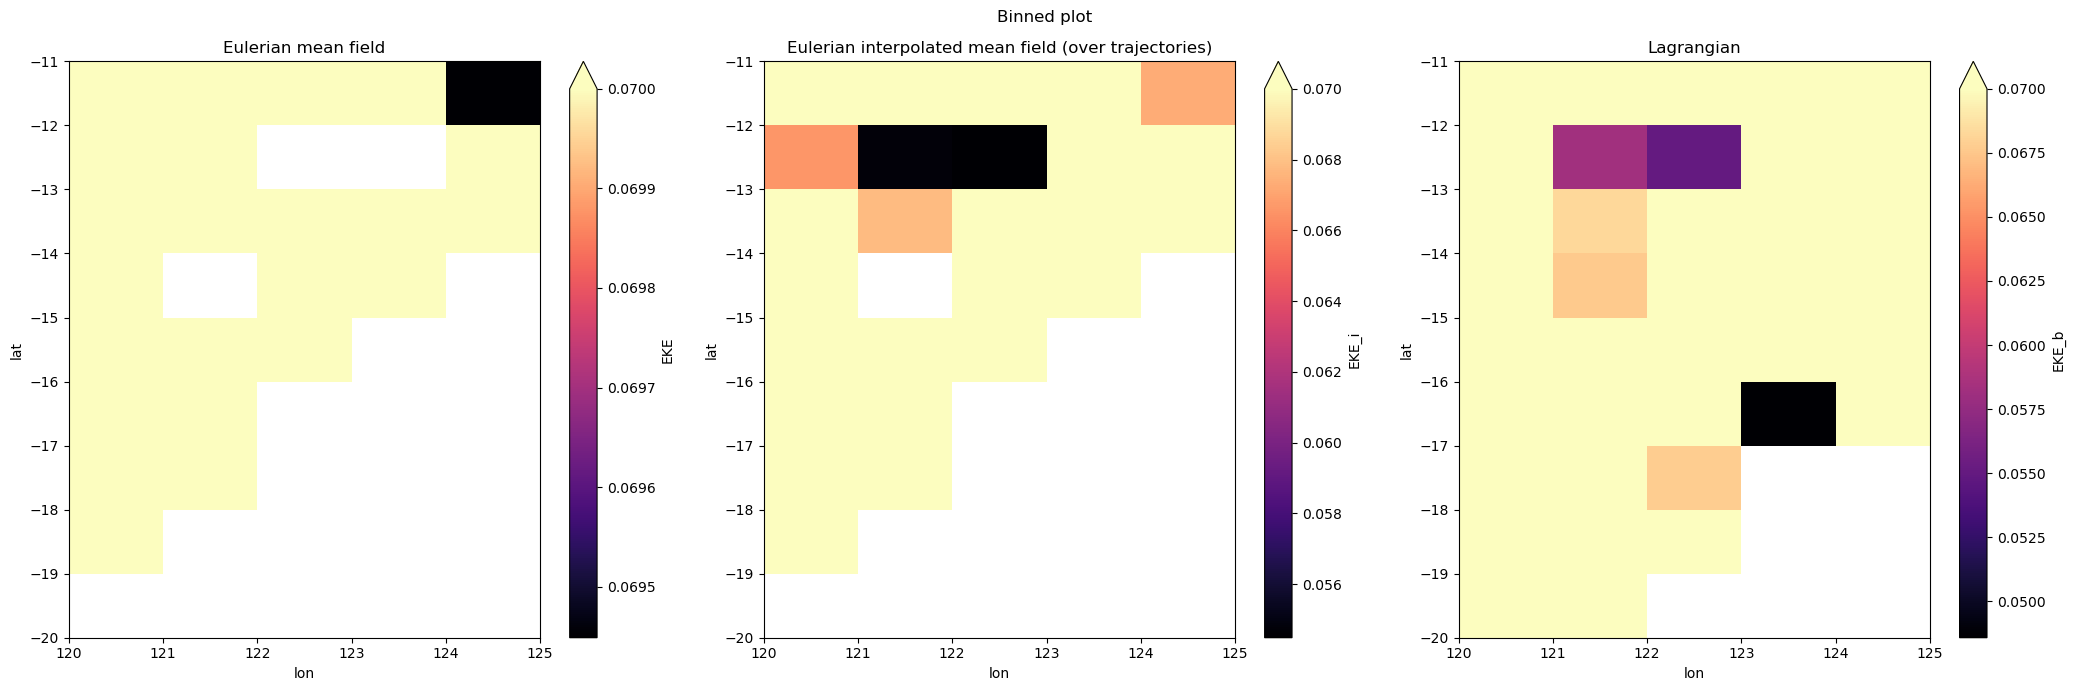

In [32]:
vmax=0.07
fig, axs = plt.subplots(1, 3, 
                           figsize=(21,7),
                          )

dfE_1dl['EKE'].plot(x='lon',y='lat',cmap='magma',ax=axs[0],vmax=vmax)
dfL_1dl['EKE_i'].plot(x='lon',y='lat',cmap='magma',ax=axs[1],vmax=vmax)
dfL_1dl['EKE_b'].plot(x='lon',y='lat',cmap='magma',ax=axs[2],vmax=vmax)

for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs):
    ax.set_title(title)
fig.suptitle('Binned plot')
fig.tight_layout()

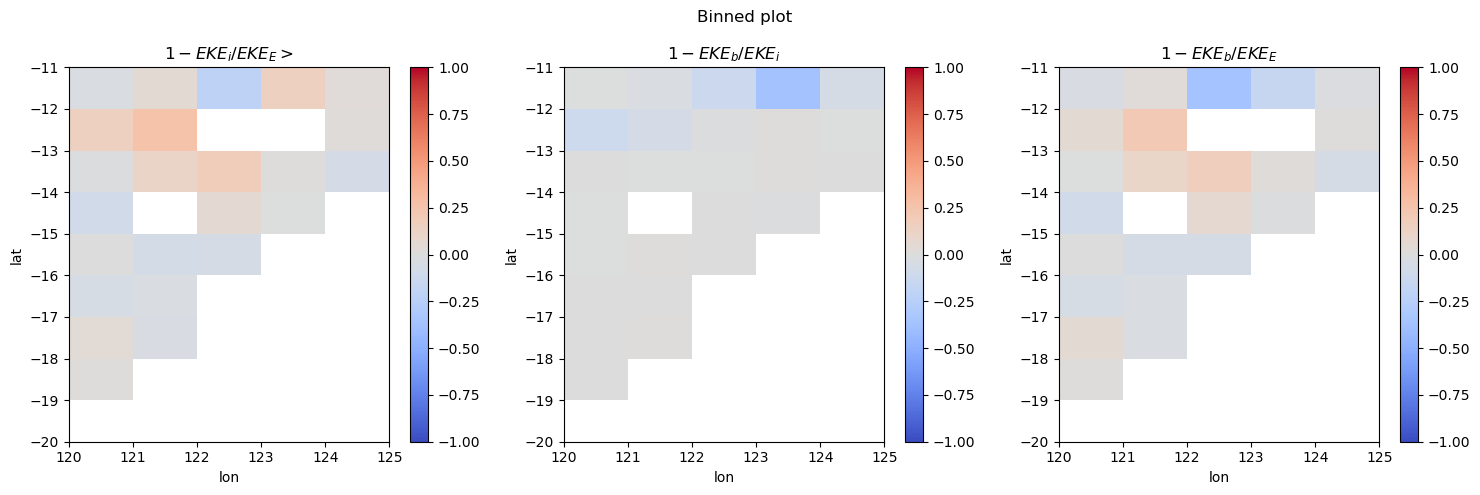

In [42]:
cmap='coolwarm'
fig, axs = plt.subplots(1,3,figsize=(15,5))
(1-np.abs(dfL_1dl['EKE_i']/dfE_1dl['EKE'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[0],vmax=1)
(1-np.abs(dfL_1dl['EKE_b']/dfL_1dl['EKE_i'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[1],vmax=1)
(1-np.abs(dfL_1dl['EKE_b']/dfE_1dl['EKE'])).plot(x='lon',y='lat',cmap=cmap,ax=axs[2],vmax=1)

for title,ax in zip([r'$1-EKE_i/EKE_E>$',r'$1-EKE_b/EKE_i$',r'$1-EKE_b/EKE_E$'],axs[:]):
    ax.set_title(title)

fig.suptitle('Binned plot')
fig.tight_layout()

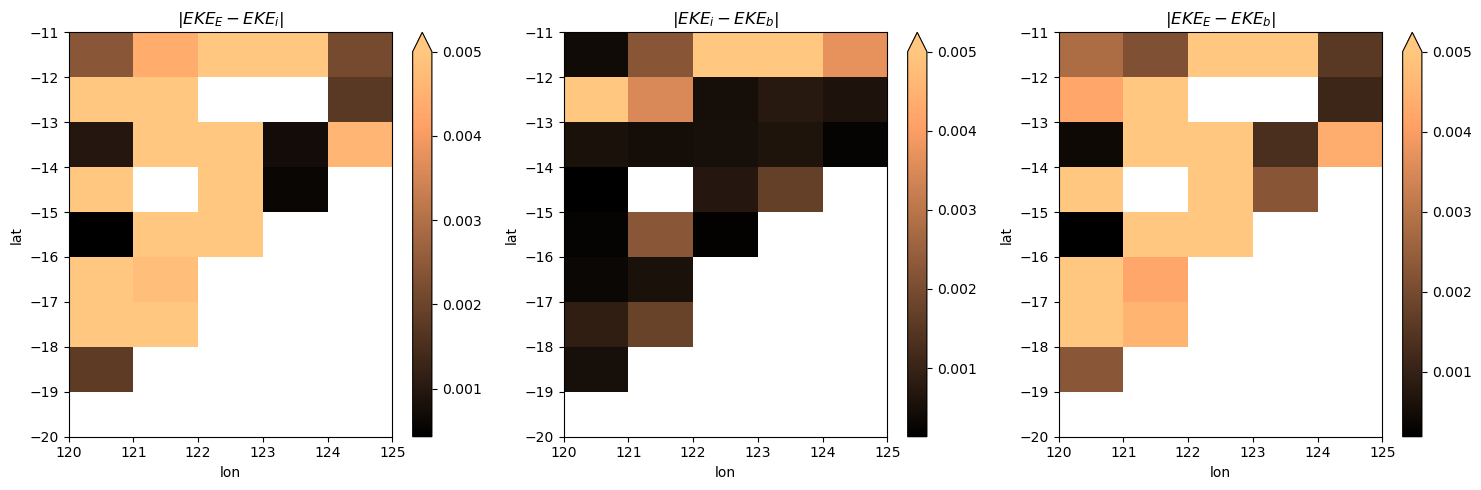

In [43]:
cmap='copper'
fig, axs = plt.subplots(1,3,figsize=(15,5))
np.abs(dfE_1dl['EKE']-dfL_1dl['EKE_i']).plot(x='lon',y='lat',cmap=cmap,ax=axs[0],vmax=0.005)
np.abs(dfL_1dl['EKE_i']-dfL_1dl['EKE_b']).plot(x='lon',y='lat',cmap=cmap,ax=axs[1],vmax=0.005)
np.abs(dfE_1dl['EKE']-dfL_1dl['EKE_b']).plot(x='lon',y='lat',cmap=cmap,ax=axs[2],vmax=0.005)

for title,ax in zip([r'$\vert EKE_E-EKE_i\vert$',r'$\vert EKE_i-EKE_b\vert$',r'$\vert EKE_E-EKE_b\vert$'],axs[:]):
    ax.set_title(title)

fig.tight_layout()

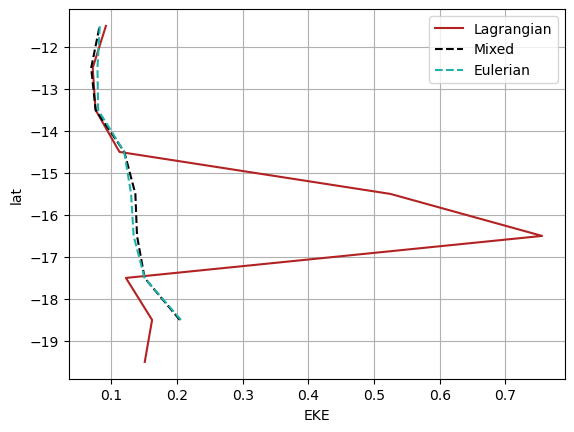

In [33]:
dfL_1dl.mean('lon').EKE_b.plot(y='lat',c='firebrick',label=r'Lagrangian')
dfL_1dl.mean('lon').EKE_i.plot(y='lat',c='k',linestyle='--',label=r'Mixed')
dfE_1dl.mean('lon').EKE.plot(y='lat',c='lightseagreen',linestyle='--',label=r'Eulerian')
plt.legend();plt.grid()

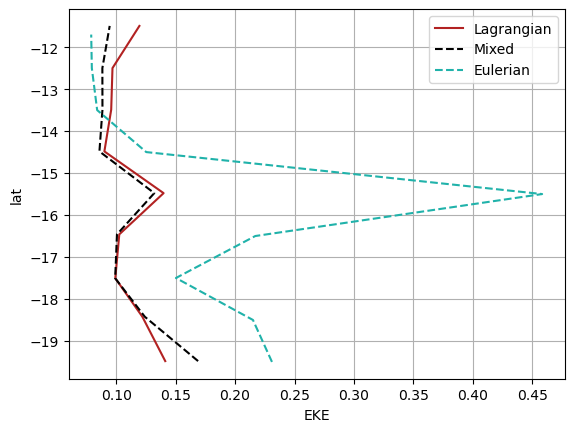

In [34]:
dfL_1dlat.EKE_b.plot(y='lat',c='firebrick',label=r'Lagrangian')
dfL_1dlat.EKE_i.plot(y='lat',c='k',linestyle='--',label=r'Mixed')
dfE_1dlat.EKE.plot(y='lat',c='lightseagreen',linestyle='--',label=r'Eulerian')
plt.legend();plt.grid()

### Differences : 
$<(u_L-\bar u_{E,i})**2>_{b,t}$

$<(u_L-<\bar u_{E,i}>_{b,t})**2>_{b,t}$

$<(u_L- <u_{L}>_{b,t})**2>_{b,t}$

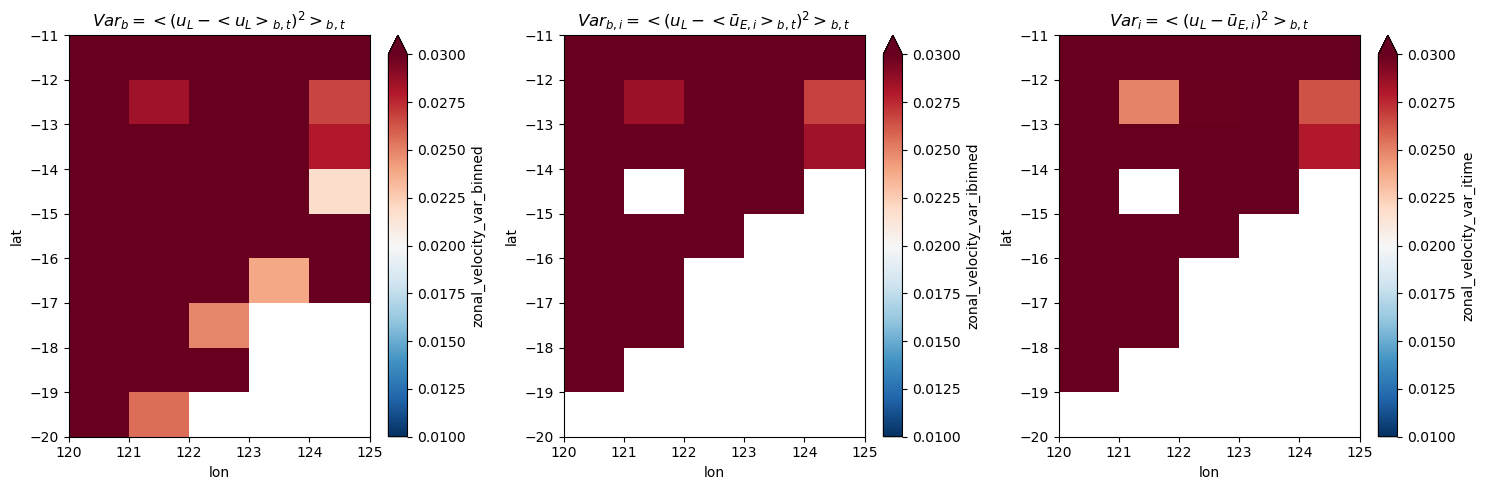

In [35]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
for V,ax,title in zip(['binned','ibinned','itime'],axs,[r'$Var_b = <(u_L-<u_{L}>_{b,t})^2>_{b,t}$',r'$Var_{b,i} = <(u_L-<\bar u_{E,i}>_{b,t})^2>_{b,t}$',r'$Var_i = <(u_L-\bar u_{E,i})^2>_{b,t}$']):
    dfL_1dl['zonal_velocity_var_'+V].plot(y='lat',cmap='RdBu_r',ax=ax,vmax=0.03,vmin=0.01)
    ax.set_title(title)
fig.tight_layout()

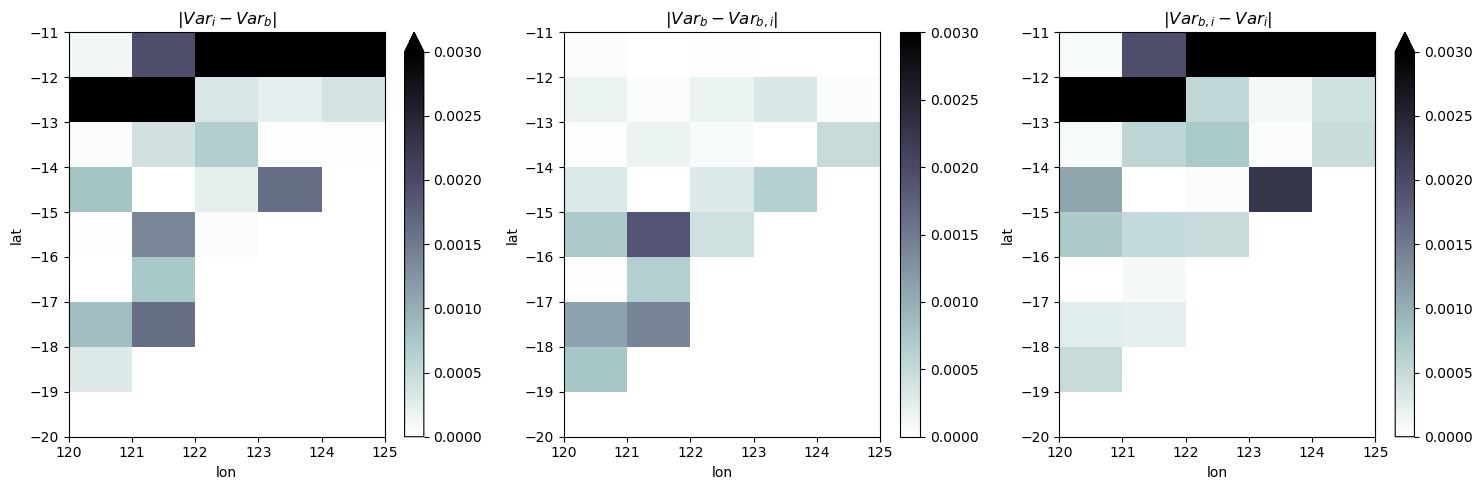

In [36]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
v = 'itime'
for V,ax,title in zip(['binned','ibinned','itime'],axs,[r'$\vert Var_i-Var_b\vert$',r'$\vert Var_b-Var_{b,i}\vert$',r'$\vert Var_{b,i}-Var_i\vert$']):
    np.abs(dfL_1dl['zonal_velocity_var_'+v]-dfL_1dl['zonal_velocity_var_'+V]).plot(y='lat',cmap='bone_r',ax=ax,vmin=0,vmax=0.003)
    ax.set_title(title)
    v=V
    
fig.tight_layout()

#### Notes : 
As expected the difference between varianc using binned and interpolated binned velocity is lower than the other differences

### dl=0.1

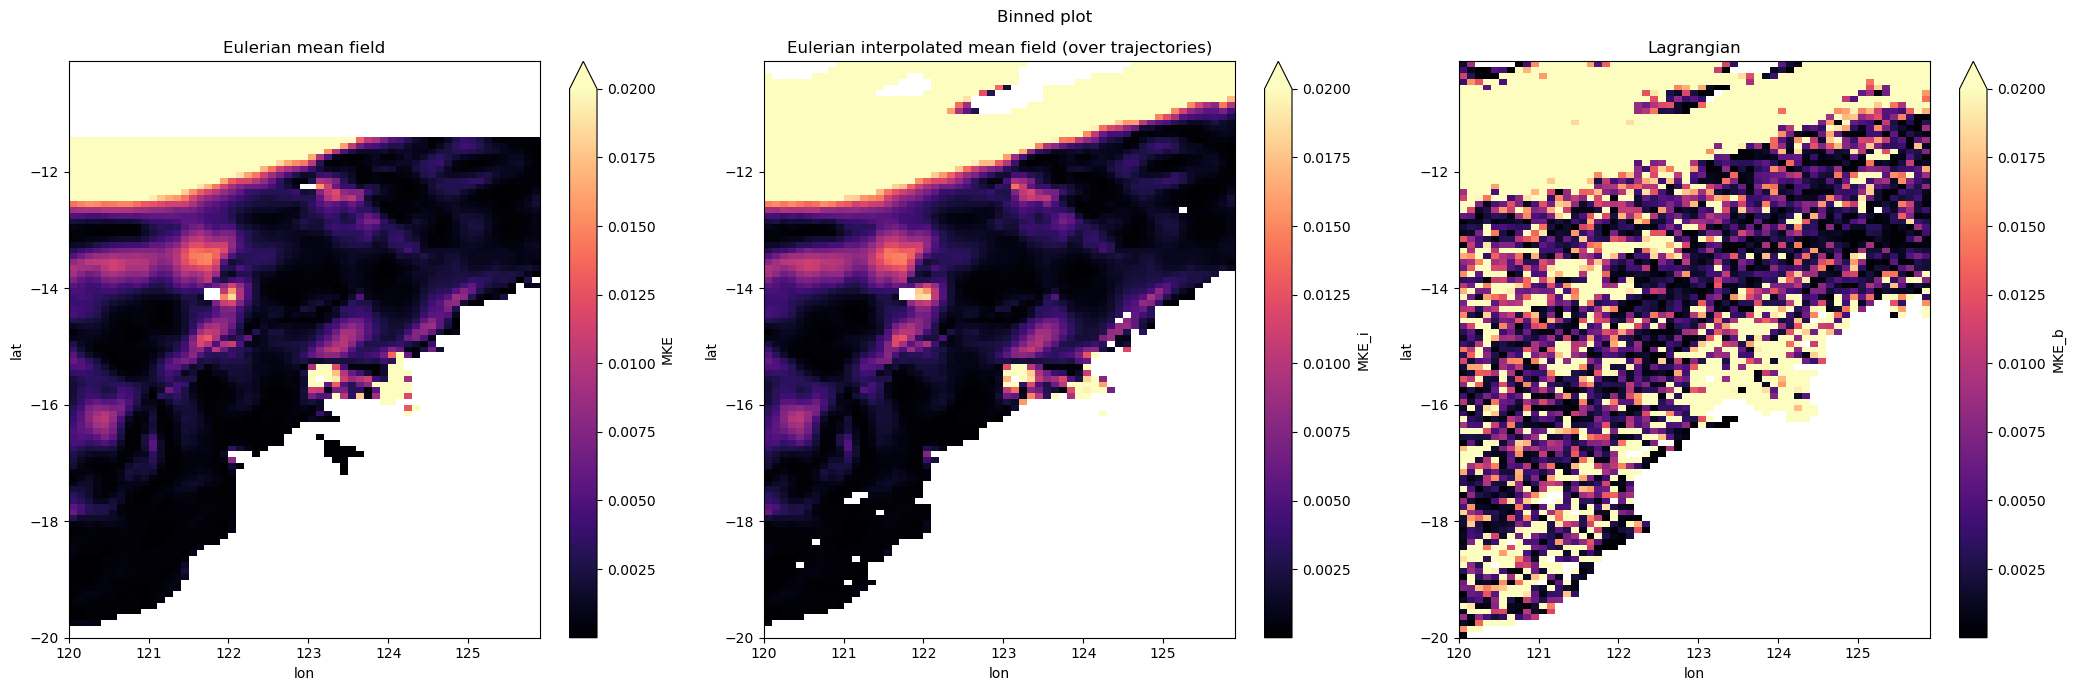

In [37]:
vmax=0.02
fig, axs = plt.subplots(1, 3, 
                           figsize=(21,7),
                          )

dfE_01dl['MKE'].plot(x='lon',y='lat',cmap='magma',ax=axs[0],vmax=vmax)
dfL_01dl['MKE_i'].plot(x='lon',y='lat',cmap='magma',ax=axs[1],vmax=vmax)
dfL_01dl['MKE_b'].plot(x='lon',y='lat',cmap='magma',ax=axs[2],vmax=vmax)

for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs):
    ax.set_title(title)
fig.suptitle('Binned plot')
fig.tight_layout()

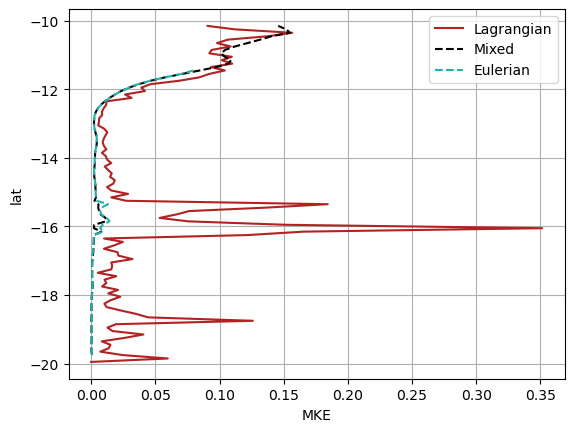

In [38]:
dfL_01dl.mean('lon').MKE_b.plot(y='lat',c='firebrick',label=r'Lagrangian')
dfL_01dl.mean('lon').MKE_i.plot(y='lat',c='k',linestyle='--',label=r'Mixed')
dfE_01dl.mean('lon').MKE.plot(y='lat',c='lightseagreen',linestyle='--',label=r'Eulerian')
plt.legend();plt.grid()

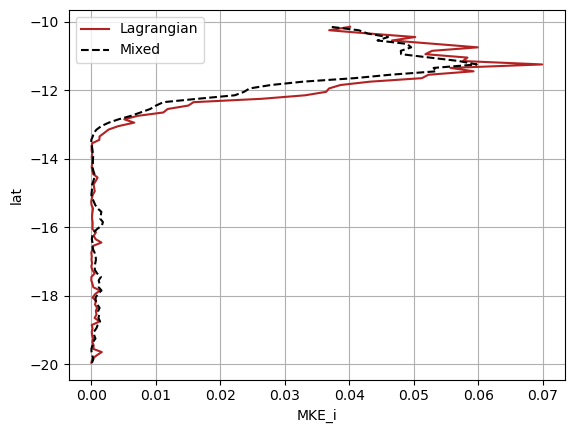

In [39]:
dfL_01dlat.MKE_b.plot(y='lat',c='firebrick',label=r'Lagrangian')
dfL_01dlat.MKE_i.plot(y='lat',c='k',linestyle='--',label=r'Mixed')
#dfE_1dlat.MKE.plot(y='lat',c='lightseagreen',linestyle='--',label=r'Eulerian')
plt.legend();plt.grid()

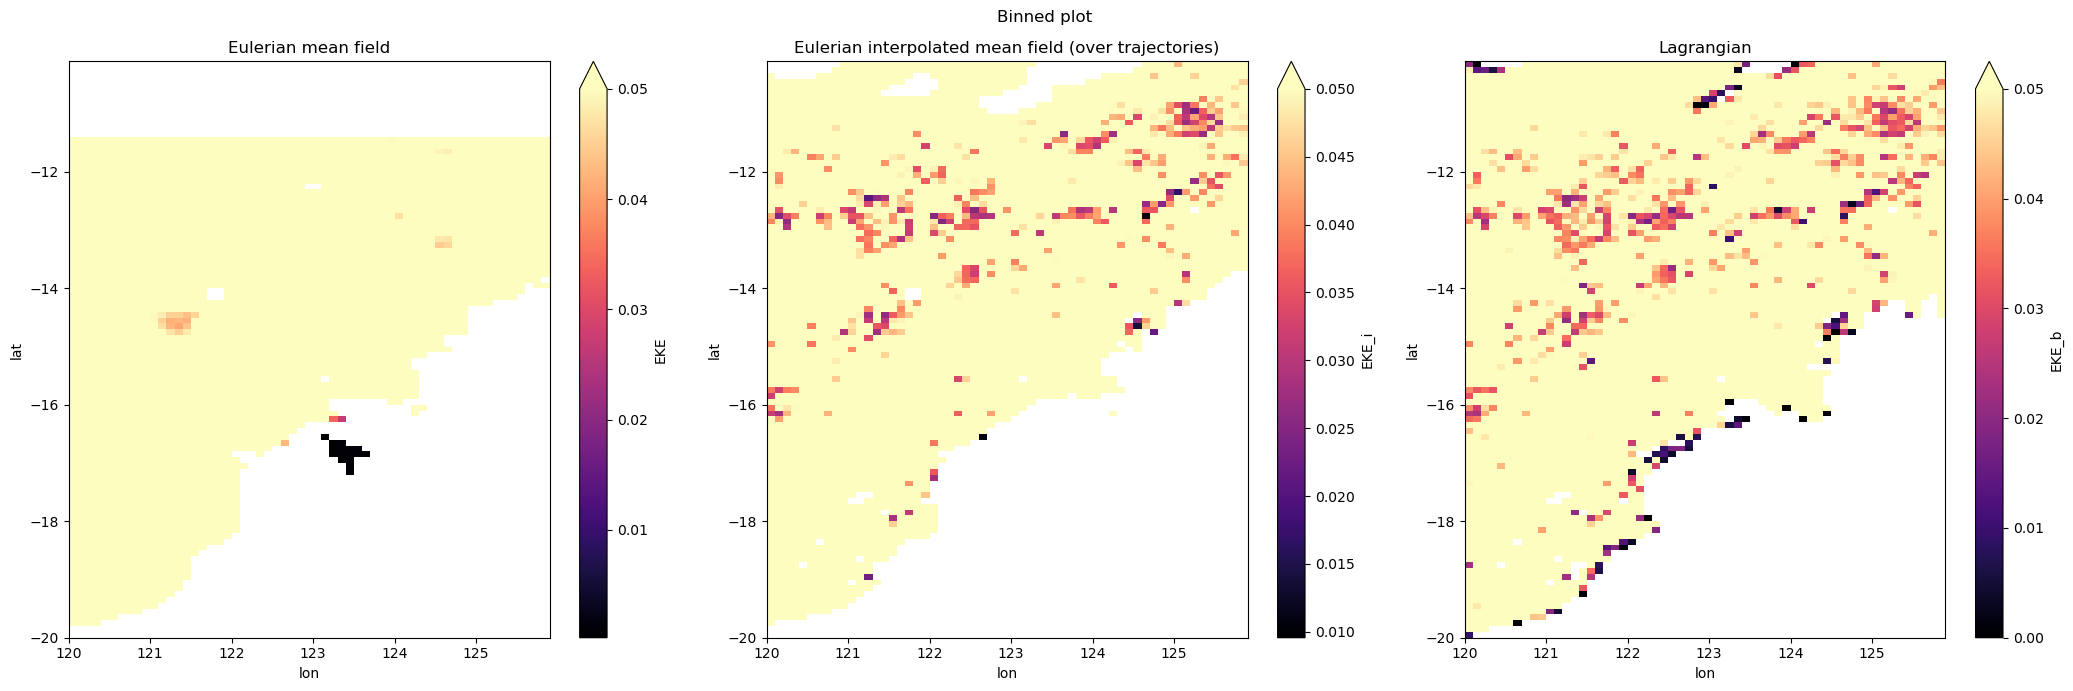

In [51]:
vmax=0.05
fig, axs = plt.subplots(1, 3, 
                           figsize=(21,7),
                          )

dfE_01dl['EKE'].plot(x='lon',y='lat',cmap='magma',ax=axs[0],vmax=vmax)
dfL_01dl['EKE_i'].plot(x='lon',y='lat',cmap='magma',ax=axs[1],vmax=vmax)
dfL_01dl['EKE_b'].plot(x='lon',y='lat',cmap='magma',ax=axs[2],vmax=vmax)

for title,ax in zip(['Eulerian mean field','Eulerian interpolated mean field (over trajectories)','Lagrangian'],axs):
    ax.set_title(title)
fig.suptitle('Binned plot')
fig.tight_layout()

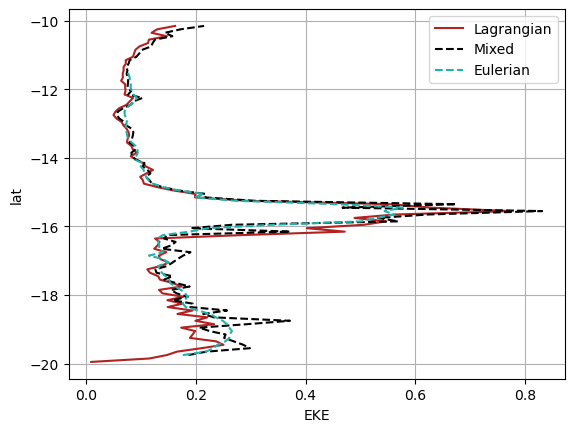

In [52]:
dfL_01dl.mean('lon').EKE_b.plot(y='lat',c='firebrick',label=r'Lagrangian')
dfL_01dl.mean('lon').EKE_i.plot(y='lat',c='k',linestyle='--',label=r'Mixed')
dfE_01dl.mean('lon').EKE.plot(y='lat',c='lightseagreen',linestyle='--',label=r'Eulerian')
plt.legend();plt.grid()

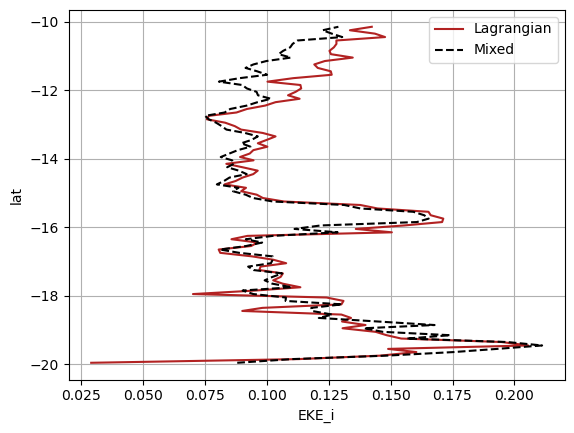

In [41]:
dfL_01dlat.EKE_b.plot(y='lat',c='firebrick',label=r'Lagrangian')
dfL_01dlat.EKE_i.plot(y='lat',c='k',linestyle='--',label=r'Mixed')
#dfE_1dlat.EKE.plot(y='lat',c='lightseagreen',linestyle='--',label=r'Eulerian')
plt.legend();plt.grid()

In [42]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
